# Modulacion en frecuencias Integrada

In [1]:
#Importamos algunas librerias necesarias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
from nltk.tokenize import word_tokenize
import we_to_signal as wes

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\PC\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\PC\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Modulación

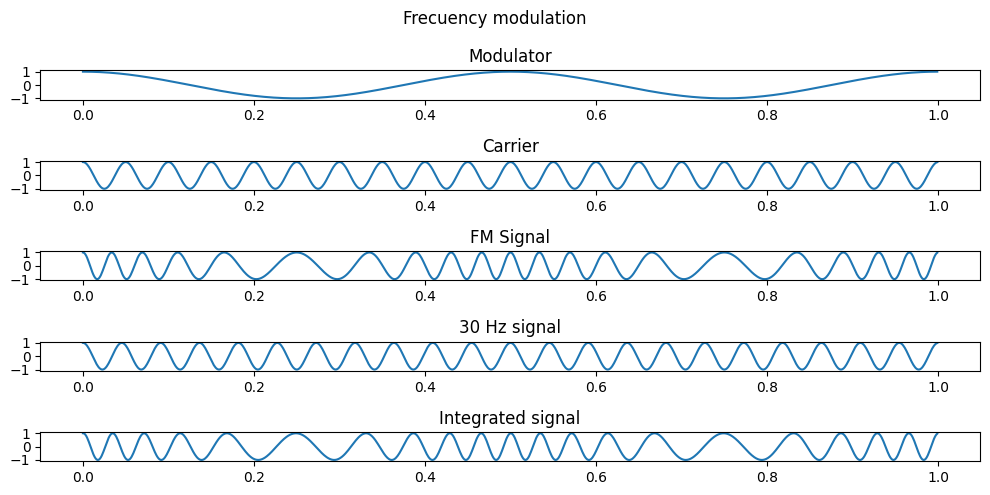

In [2]:
from scipy.integrate import simpson

#Asignamos el valor de dt
dt = 0.001
t = np.arange(0,1,dt)

#Calculamos la señal portadora
f_carrier = 20
carrier = np.cos(2*np.pi*f_carrier*t)

#Calculamos la señal moduladora
f_moduladora = 2
moduladora = np.cos(2*np.pi*f_moduladora*t)

#Calculamos la señal en fm con el seno
k = 10
sig_modulada = np.cos(2*np.pi*f_carrier*t + (k/f_moduladora)*np.sin(2*np.pi*f_moduladora*t))

#Calculamos la integral de la señal moduladora respecto al tiempo
integral = [simpson(y=moduladora[:i],dx=dt) for i in range(1,len(moduladora))]
integral.insert(0,0)
integral = np.array(integral)

#Calculamos la señal en frecuencia modulada con los valores de la integral
k_int = 58
sig_modulada_integrada = np.cos(2*np.pi*f_carrier*t + k_int*integral)

fig,ax = plt.subplots(5,figsize=(10,5))

fig.suptitle("Frecuency modulation")

ax[0].set_title("Modulator")
ax[0].plot(t,moduladora)

ax[1].set_title("Carrier")
ax[1].plot(t,carrier)

ax[2].set_title("FM Signal")
ax[2].plot(t,sig_modulada)

ax[3].set_title("30 Hz signal")
ax[3].plot(t,np.cos(2*np.pi*22*t))

ax[4].set_title("Integrated signal")
ax[4].plot(t,sig_modulada_integrada)

fig.tight_layout()

In [3]:
def modulate(moduladora,carrier_hz,k,dt,duration_s):
    """Ocupa x para modular una carrier de amplitud 1 y frecuencia carrier_hz"""
    # Samples per second sps

    # Duration duration_s in seconds

    # carrier_hz: Frequency of the carrier
    # fm_hz: Frequency of the frequency modulator
    # k_p: deviation constant

    t = np.arange(0,duration_s,dt)

    carrier_phi = 2*np.pi*t*carrier_hz
    
    integral = [simpson(y=moduladora[:i],dx=dt) for i in range(1,len(moduladora))]
    integral.insert(0,0)
    integral = np.array(integral)
    
    fm_signal = np.cos(carrier_phi + k*integral)

    return fm_signal

## Carga de corpus

In [4]:
#Con los poemas separados, los metemos en un diccionario de dataframes
import os

data_path = "data/"
emotion_list = ["anger", "anticipation", "disgust", "fear", "joy", "sadness", "surprise", "trust"]

json_files = sorted([pos_json for pos_json in os.listdir(data_path) if pos_json.endswith('.json')])
json_files.remove('Poems.json')
json_files.remove('missing.json')

em_poems = {}
for e in emotion_list:
    f = open(data_path+e+".json")
    df_ = pd.DataFrame(json.load(f))
    em_poems[e] = df_
em_poems["anger"]

,poem,id
0,i do know this it's nothing i can hold\nlast ...,10
1,the fear o' hell's a hangman's whip\nto haud t...,18
2,but since i laid a hand thereon\nand found a h...,88
3,falsely i pointed to sum in text\nseriously he...,99
4,i'll wear my jealous reflection\njuice of lemo...,125
...,...,...
2461,new snow on a leaf\nlike granulated sugar\nmak...,93124
2462,new earth and old earth\na trio of guardians\n...,93138
2463,destructions despair\nconstructions hope toge...,93217
2464,hot dry summers will\nbake paint right off the...,93226


In [5]:
#Carga de embeddings
from gensim.models import Word2Vec
from gensim.models import FastText

emotion_list = ["anger", "anticipation", "disgust", "fear", "joy", "sadness", "surprise", "trust"]

poems_w2v = {}
poems_fst = {}

for e in emotion_list:
    w2v_lines = Word2Vec.load("embeddings_poems/w2v_model_"+e)
    fst_lines = FastText.load("embeddings_poems/fst_model_"+e)
    poems_w2v[e] = w2v_lines
    poems_fst[e] = fst_lines

## Similitud entre emociones


In [6]:
#Calculamos la interseccion entre palabras de fst,w2v y todas las emociones

words_intersection = set()
for emotion in emotion_list:
    fst = set(poems_fst[emotion].wv.key_to_index.keys())
    w2v = set(poems_w2v[emotion].wv.key_to_index.keys())
    intersection = fst & w2v
    if not words_intersection:
        words_intersection = words_intersection.union(intersection)
    else:
        words_intersection = words_intersection.intersection(intersection)

display(len(words_intersection))

677

In [7]:
#Eliminamos las stopwords de la interseccion
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
words_intersection = words_intersection - stop_words
len(words_intersection)

562

In [8]:
#Funciones de procesamiento y obtencion de frecuencia de las palabras
from collections import Counter

def get_word_freq(dataframe:pd.DataFrame,col:str,emotion_list:list):
    """
    Calculates for Counter model of each emotion text corpus.

    Parameters
    ------------
    dataframe: pandas Dataframe with documents.
    col:str name of the column where the documents are.
    emotion_list: list with emotions

    Returns
    -----------
    dict:
        dictionary with keys(emotions_list) an each key with his self Counter model.
    """
    freq_dict = {}
    for emotion in emotion_list:
        tokens = dataframe[emotion][col].apply(lambda x: [token for token in word_tokenize(x)])
        l1 = tokens.values.tolist()
        l2 = [w for l in l1 for w in l ]
        freq_dict[emotion] = Counter(l2)
    return freq_dict

def text_clean(sent):
    """
    Clean the text of some chars
    
    Parameters
    -------------
    sent: str
        Sentence to be cleaned
    
    Returns
    -------------
    str:
        Sentence cleaned.
    """
    import re
    from unidecode import unidecode
    import unicodedata as ud

    d = {ord('\N{combining acute accent}'):None}
    sent = ud.normalize('NFD',sent).translate(d)
    sent = re.sub(r"[^\w .,;?!\n]+", "", sent)
    sent = re.sub(r"[^\w .,;?!]", " ", sent)
    sent = re.sub(r"[^\w .,]", ".", sent)
    sent = re.sub(r"[^\w ]", "", sent)
    sent = re.sub(r"[0-9]", "", sent)
    sent = re.sub(r"[α-ωςϑϕϜϝϞϠϰϱ]", "", sent)
    sent = re.sub(r"[ΓΔΕΖΗΘΙΚΛΜΝΞΟΠΡΣΤΥΦΧΨΩ]", "", sent)
    sent = re.sub(r"[A-Z]{2}", "", sent)
    return sent

In [9]:
#Creamos una copia de los poemas y calculamos la frecuencia de aparición de las palabras
em_poem_c = dict()

for emotion in emotion_list:
    em_poem_c[emotion] = em_poems[emotion].copy()

for emotion in emotion_list:
    em_poem_c[emotion]["poems_clean"] = em_poem_c[emotion]["poem"].apply(text_clean)

freq_dict = get_word_freq(em_poem_c,"poems_clean",emotion_list)

In [10]:
#Creamos el dataframe de las palabras con su correlacion pearson
from itertools import combinations
from scipy.stats import pearsonr

def create_correlation_df(models,emotion_list,words_intersection,freq_dict):
    """
    Crea un dataset con informacion de la correlacion de las palabras
    entre emociones añadiendo su frecuencia de aparicion en el corpus.
    """
    emotion_combinations = list(combinations(emotion_list,2))

    words_embbed_info = {}
    words_embbed_info["words"] = list(words_intersection)

    for emotion in emotion_list:
        words_embbed_info["f_"+emotion] = []

    for comb in emotion_combinations:
        words_embbed_info["P_"+str(comb)] = []

    for word in words_intersection:
        #Añadimos la frecuencia por cada emoción
        for emotion in emotion_list:
            words_embbed_info["f_"+emotion].append(freq_dict[emotion][word])

        #Calculamos la correlacion pearson para cada par de emociones.    
        for comb in emotion_combinations:
            emotion_a = comb[0]
            emotion_b = comb[1]

            words_embbed_info["P_"+str(comb)].append(pearsonr(models[emotion_a].wv.get_vector(word,norm=True),models[emotion_b].wv.get_vector(word,norm=True)))

    return pd.DataFrame(words_embbed_info)

In [11]:
words_embbed_w2v_info = create_correlation_df(poems_w2v,emotion_list,words_intersection,freq_dict)
words_embbed_fst_info = create_correlation_df(poems_fst,emotion_list,words_intersection,freq_dict)

display(words_embbed_w2v_info)
display(words_embbed_fst_info)

,words,f_anger,f_anticipation,f_disgust,f_fear,f_joy,f_sadness,f_surprise,f_trust,"P_('anger', 'anticipation')",...,"P_('fear', 'joy')","P_('fear', 'sadness')","P_('fear', 'surprise')","P_('fear', 'trust')","P_('joy', 'sadness')","P_('joy', 'surprise')","P_('joy', 'trust')","P_('sadness', 'surprise')","P_('sadness', 'trust')","P_('surprise', 'trust')"
0,someone,9,31,9,26,33,37,10,33,"(0.9170810235715009, 6.388810139360471e-41)",...,"(0.8636547847306587, 6.4964298678711735e-31)","(0.8679808990876708, 1.491933520007352e-31)","(0.8653617986528516, 3.657751862167497e-31)","(0.8569244170275062, 5.812283352290499e-30)","(0.8746167553035459, 1.4077473594422e-32)","(0.8707147738154153, 5.731070188504899e-32)","(0.8748262729498093, 1.303802893304618e-32)","(0.8846009749444327, 3.0969116467043477e-34)","(0.8927128819232193, 1.065101754810428e-35)","(0.8833246407700762, 5.142762531515915e-34)"
1,stood,25,106,19,94,76,88,17,109,"(0.9068077756692469, 1.518494788712324e-38)",...,"(0.8512889903837756, 3.346239238575115e-29)","(0.87953641416297, 2.2393562179849272e-33)","(0.8814835149246741, 1.0579059734375233e-33)","(0.8685554773147081, 1.2223475741113075e-31)","(0.8802890691970896, 1.6784336215062576e-33)","(0.8884375997217415, 6.498968502180044e-35)","(0.8641372665409462, 5.527249072211746e-31)","(0.8953830334955051, 3.309779186595743e-36)","(0.8803468768190877, 1.641541821112889e-33)","(0.8610469438998267, 1.5393462947889258e-30)"
2,rough,17,18,5,19,19,30,8,17,"(0.8654088306735263, 3.599919512191158e-31)",...,"(0.8612215440709368, 1.4537524828842115e-30)","(0.883923342405494, 4.0569080809957535e-34)","(0.8762651295813662, 7.670249851738449e-33)","(0.8827844680529012, 6.362762314723704e-34)","(0.8866272762209244, 1.3672374170710463e-34)","(0.8788008178484925, 2.9627727031488815e-33)","(0.8872256228090943, 1.0707727858138605e-34)","(0.8957351366089686, 2.8303638904039363e-36)","(0.8958967112115361, 2.6337626139752757e-36)","(0.8741725591319546, 1.6555934864790023e-32)"
3,think,64,173,36,123,203,148,19,245,"(0.864399485402527, 5.061304130379116e-31)",...,"(0.8026929525229848, 1.0010535717247034e-23)","(0.7976190970471722, 3.0441553491759254e-23)","(0.8481602974701257, 8.574068516352369e-29)","(0.7554266912870307, 1.0730341592779288e-19)","(0.7467842992399104, 4.670995175118243e-19)","(0.7536372046937686, 1.4623165010549027e-19)","(0.707445963956635, 1.90718249334115e-16)","(0.8076246751815899, 3.2911473104275582e-24)","(0.7804788380859442, 1.0441455232537836e-21)","(0.795797708894315, 4.5031816931923054e-23)"
4,thousand,16,55,9,47,63,50,6,77,"(0.9120690557710015, 1.0021624897851723e-39)",...,"(0.8591907463573046, 2.81452214110548e-30)","(0.8863386983755692, 1.5375337049172796e-34)","(0.8875898435006132, 9.22127036719209e-35)","(0.8807779294952287, 1.3903398564260932e-33)","(0.8898702897346296, 3.5747561213682107e-35)","(0.8812211840590966, 1.1712698861746524e-33)","(0.879197973741389, 2.5477512494718045e-33)","(0.9029623497049345, 1.0016689424651852e-37)","(0.8934947842743394, 7.588417698263322e-36)","(0.8830361374959835, 5.7627499792314e-34)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
557,singing,13,48,6,31,101,45,13,52,"(0.904289071585488, 5.271993940967169e-38)",...,"(0.8337281360740768, 5.0797424101061516e-27)","(0.8845354357879829, 3.1790882903092583e-34)","(0.8831751363903441, 5.455435300186298e-34)","(0.8736248762986148, 2.0203402426876616e-32)","(0.8836885508703193, 4.453037521375836e-34)","(0.8825443050144245, 6.992027308542248e-34)","(0.8766545600690226, 6.636765229565824e-33)","(0.8941307315289919, 5.748422108224365e-36)","(0.8930733412032574, 9.112864850923234e-36)","(0.8795278879598301, 2.246657598609855e-33)"
558,heart,123,423,43,275,797,568,58,471,"(0.9089547511549255, 5.1092963170536204e-39)",...,"(0.8015366520043884, 1.2934755380091608e-23)","(0.8592877864830788, 2.727702157035102e-30)","(0.884995938408854, 2.643870025627479e-34)","(0.8707160172521848, 5.728548528997429e-32)","(0.

,words,f_anger,f_anticipation,f_disgust,f_fear,f_joy,f_sadness,f_surprise,f_trust,"P_('anger', 'anticipation')",...,"P_('fear', 'joy')","P_('fear', 'sadness')","P_('fear', 'surprise')","P_('fear', 'trust')","P_('joy', 'sadness')","P_('joy', 'surprise')","P_('joy', 'trust')","P_('sadness', 'surprise')","P_('sadness', 'trust')","P_('surprise', 'trust')"
0,someone,9,31,9,26,33,37,10,33,"(0.8824794417298254, 7.1721534769459035e-34)",...,"(0.8542339716837413, 1.352912955589054e-29)","(0.9027520705732821, 1.107989753724956e-37)","(0.8711796780207856, 4.860001124021375e-32)","(0.8938249367010233, 6.571066662896891e-36)","(0.783134506249645, 6.166501255762423e-22)","(0.7576636785235832, 7.260003701121345e-20)","(0.836728898721278, 2.246766242813036e-27)","(0.8913417132534033, 1.9180873837899879e-35)","(0.889148730448282, 4.835439833517281e-35)","(0.8728715553291777, 2.6528181947903104e-32)"
1,stood,25,106,19,94,76,88,17,109,"(0.879906685415068, 1.9436860093398305e-33)",...,"(0.8945651133141573, 4.7503910625494624e-36)","(0.8502977891531058, 4.518787343120226e-29)","(0.8747924609773725, 1.3200549348463822e-32)","(0.8792217825302252, 2.5247630051560028e-33)","(0.8435123900179737, 3.338557193364142e-28)","(0.8409637375518647, 6.905420406542636e-28)","(0.8698880370765136, 7.671477545923443e-32)","(0.8280205561847788, 2.294201670525438e-26)","(0.8839586179287476, 4.000448299000595e-34)","(0.8699583350585341, 7.484179204240125e-32)"
2,rough,17,18,5,19,19,30,8,17,"(0.8496164361964696, 5.548283015284599e-29)",...,"(0.8545642324970857, 1.2207503908430777e-29)","(0.8375275976139397, 1.803227800031895e-27)","(0.8694766358338153, 8.862925150268051e-32)","(0.8375910023316117, 1.77193025398384e-27)","(0.8508179345037452, 3.8607937693166425e-29)","(0.7871581018298778, 2.737251377137748e-22)","(0.8440045787768986, 2.8970502287313636e-28)","(0.794831248603442, 5.534200310361209e-23)","(0.8782874328728695, 3.5981632639910846e-33)","(0.8112109242543587, 1.4361679646611564e-24)"
3,think,64,173,36,123,203,148,19,245,"(0.754729565456541, 1.2109303934018827e-19)",...,"(0.7756386303061036, 2.6764532326639982e-21)","(0.8707033438907084, 5.754300631078365e-32)","(0.8443682340945541, 2.6079766273154998e-28)","(0.806172155892619, 4.5821791202353364e-24)","(0.7565978267495536, 8.750044882656864e-20)","(0.5882571348280353, 1.2291113082358792e-10)","(0.761476130155877, 3.69395559479407e-20)","(0.8127875541150079, 9.918320559012565e-25)","(0.8244493144581647, 5.73078485499262e-26)","(0.7163130871346463, 5.3757806505304045e-17)"
4,thousand,16,55,9,47,63,50,6,77,"(0.8914840645560996, 1.8051154018119746e-35)",...,"(0.8360246004413433, 2.7249037682892433e-27)","(0.891738758400553, 1.61898952484336e-35)","(0.8732701326484813, 2.297305569614327e-32)","(0.884336694491177, 3.4415212377464176e-34)","(0.8308161415386693, 1.1039910016623063e-26)","(0.777114966139952, 2.0135148662392385e-21)","(0.8095639516270966, 2.1064193461481245e-24)","(0.876157153557228, 7.983604727153047e-33)","(0.8980617608988404, 9.922085809116853e-37)","(0.8732458013370838, 2.317605212801394e-32)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
557,singing,13,48,6,31,101,45,13,52,"(0.776715455210838, 2.175186267507697e-21)",...,"(0.8392664349518755, 1.112563330275458e-27)","(0.8415551309699143, 5.8404629246319455e-28)","(0.8593150063958538, 2.703822217869628e-30)","(0.8339715296075623, 4.7573944747832124e-27)","(0.8529629273099487, 2.004760869014068e-29)","(0.7526059337308484, 1.745787181255865e-19)","(0.8338657575872674, 4.8949490979403525e-27)","(0.777291463027736, 1.945873831444713e-21)","(0.879438186590595, 2.3248960581958658e-33)","(0.7873107844832776, 2.65326131091444e-22)"
558,heart,123,423,43,275,797,568,58,471,"(0.8726862690734526, 2.835861113202788e-32)",...,"(0.692965499950583, 1.3672683823492965e-15)","(0.842759781472837, 4.143303178195696e-28)","(0.874869381201767, 1.2833656690111006e-32)","(0.7566748774655995, 8.633033423590926e-20)","(0.75210563201

In [12]:
# Boxplots correlacion 
def box_plot_word_info(df,suptitle:str="Box plot"):
    """Realiza un boxplot del data frame words_embbed_***_info"""
    import re
    fig,ax = plt.subplots(8,figsize=(16,30))
    columns = df.columns
    i = 0
    for emotion in emotion_list:
        data = []
        labels = []
        for column in columns:
            if emotion in column:
                if 'f_' in column:
                    continue
                data.append([element[0] for element in df[column]])
                labels.append(re.sub(r"P_","",column))
        ax[i].boxplot(data)
        ax[i].set_xticklabels(labels)
        ax[i].set_title(emotion)
        i+=1
    fig.suptitle(suptitle,y=0.9)

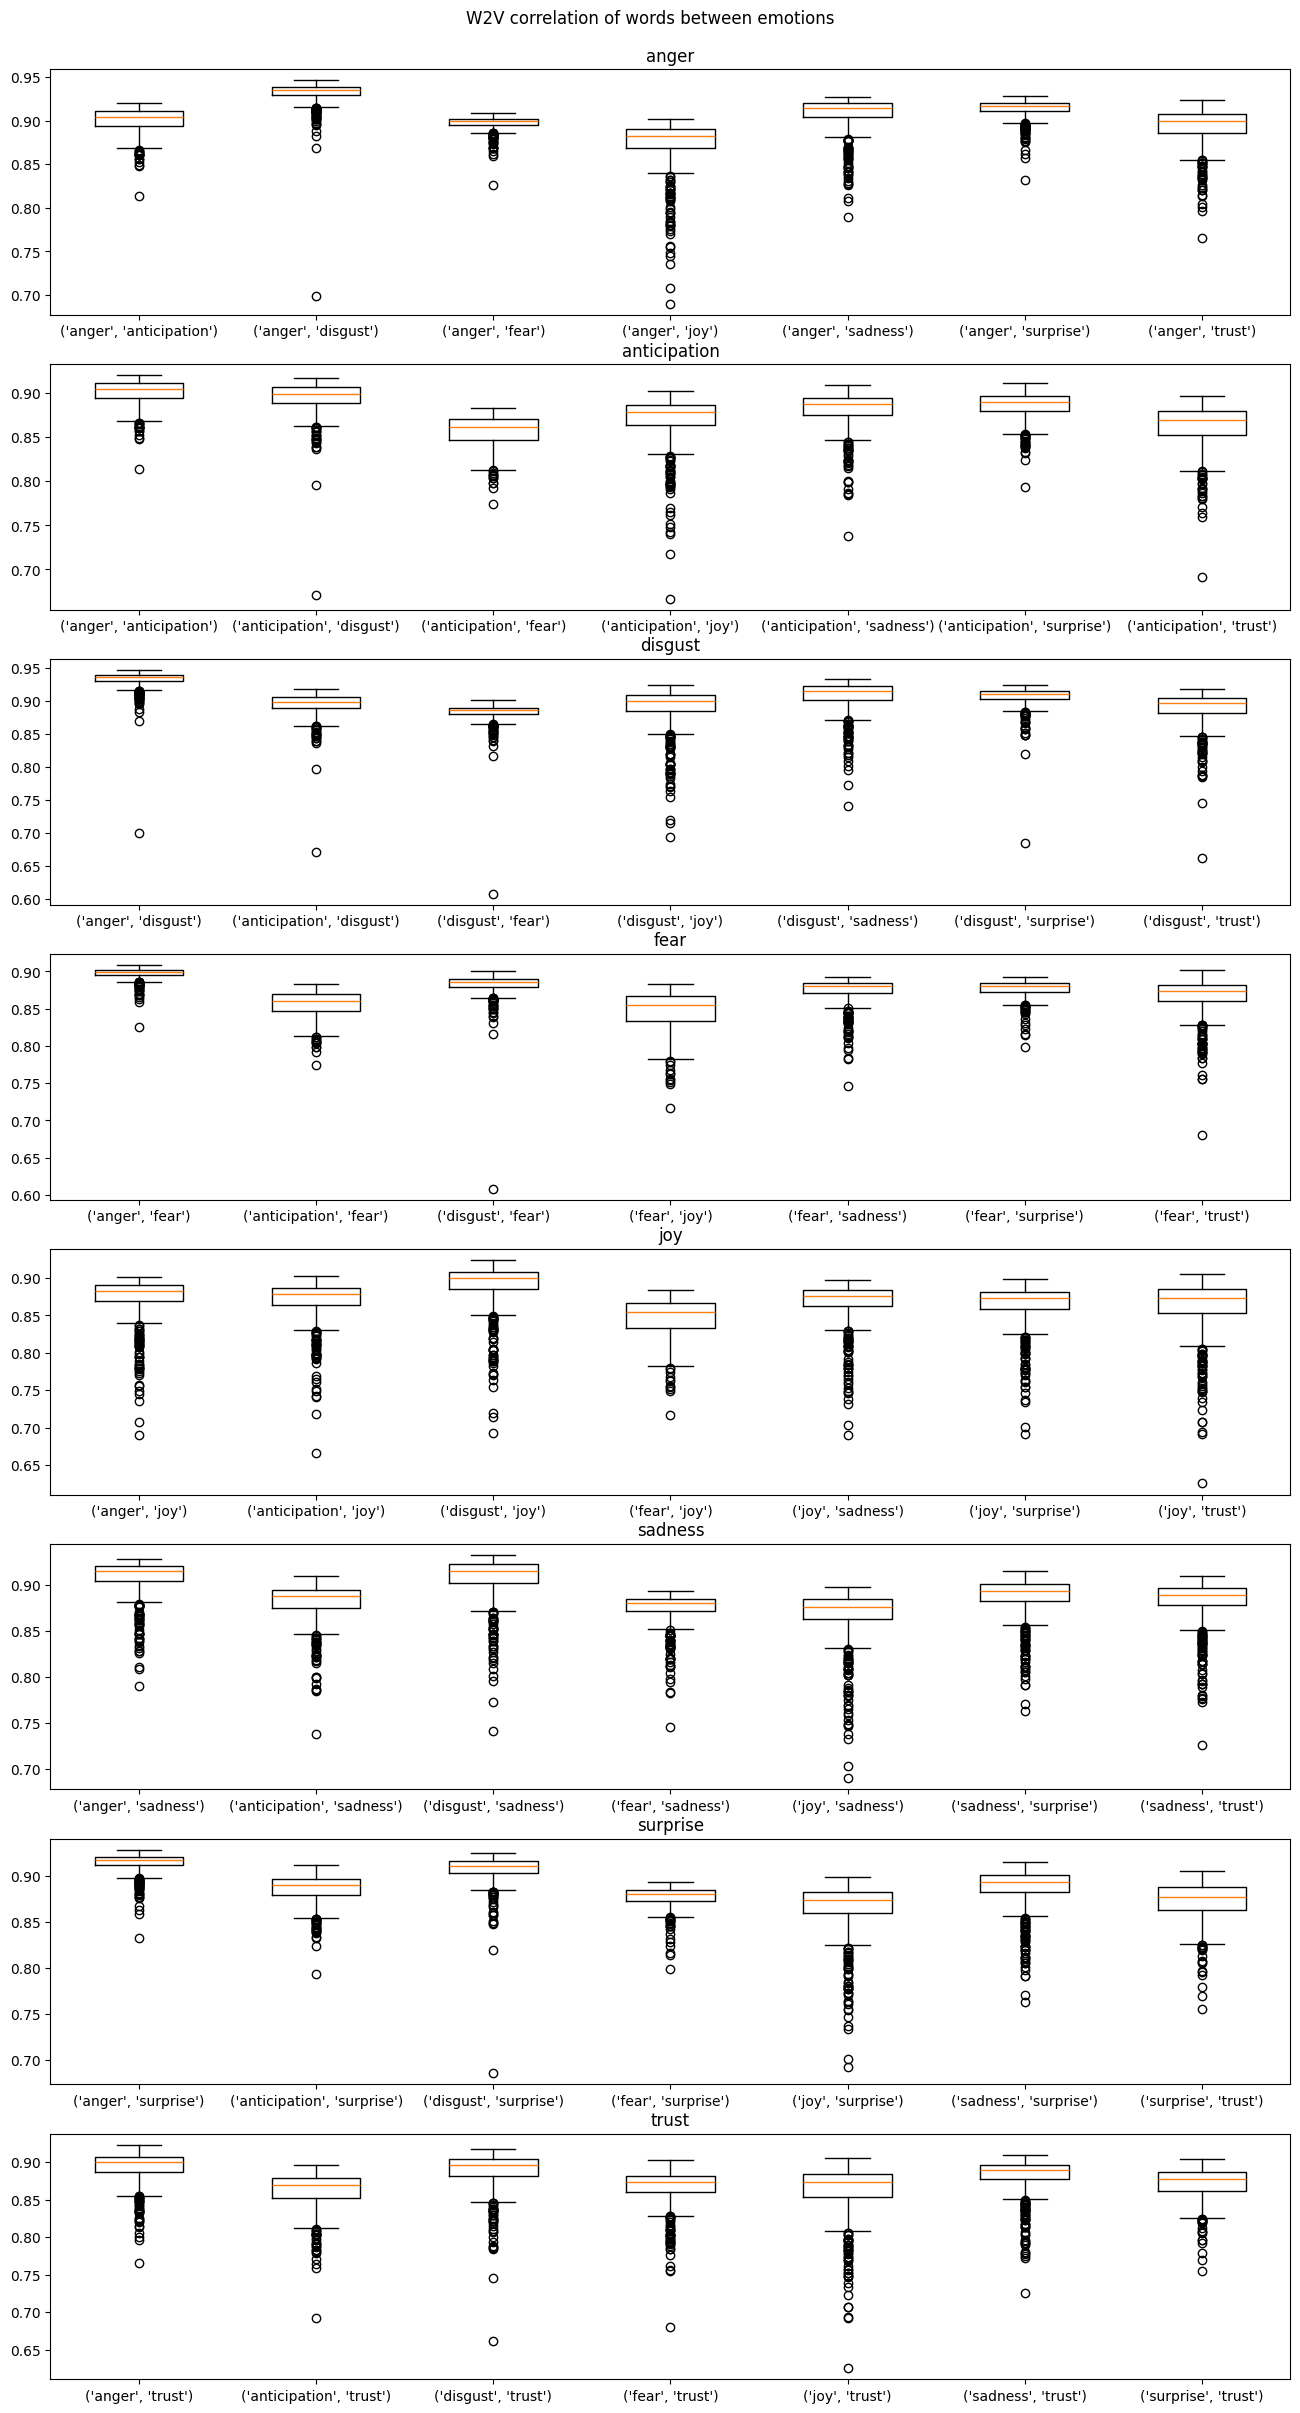

In [13]:
box_plot_word_info(words_embbed_w2v_info,"W2V correlation of words between emotions")

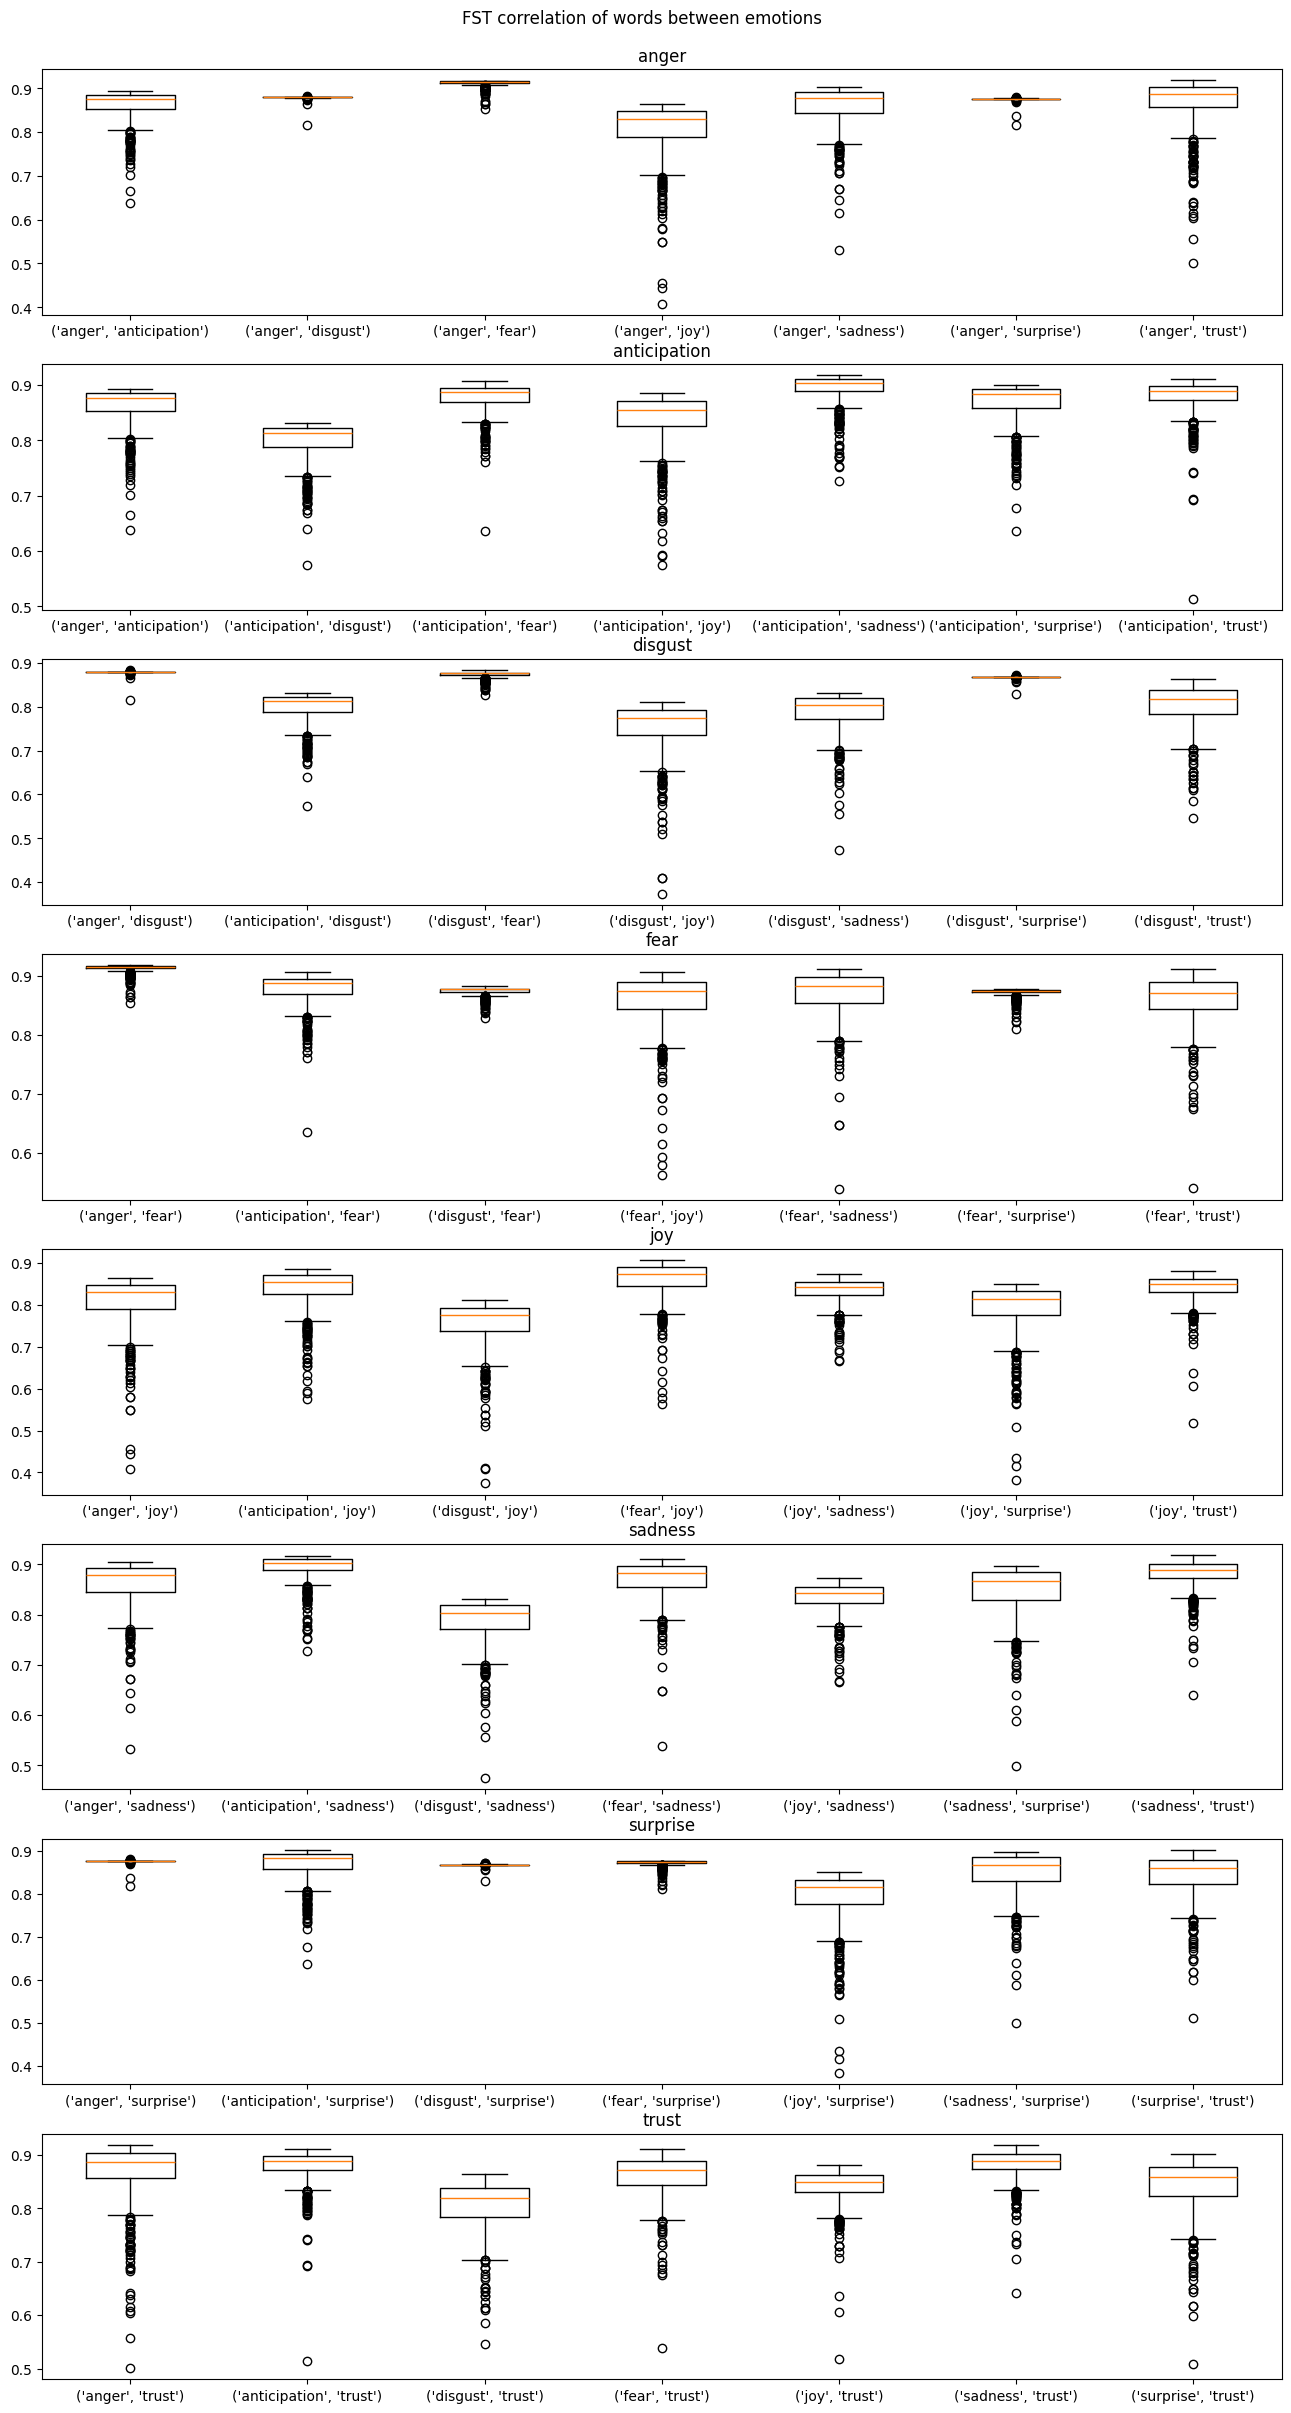

In [14]:
box_plot_word_info(words_embbed_fst_info,"FST correlation of words between emotions")

## Modulacion de embbeddings

In [26]:
word = "bring"
emotion = "anger"
embbed_w2v = poems_w2v[emotion].wv.get_vector(word,norm=True)
embbed_fst = poems_fst[emotion].wv.get_vector(word,norm=True)

fm_w2v = modulate(embbed_w2v,5,1000,1/len(embbed_w2v),1)
fm_fst = modulate(embbed_fst,5,1000,1/len(embbed_fst),1)

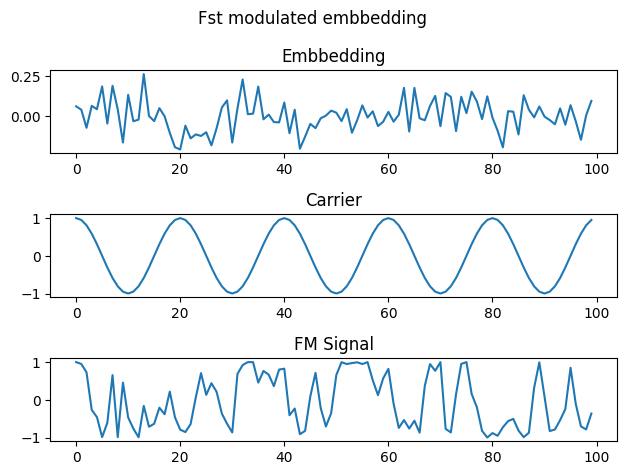

In [27]:
fig,ax = plt.subplots(3)
fig.suptitle("Fst modulated embbedding")

ax[0].set_title("Embbedding")
ax[0].plot(embbed_fst)

ax[1].set_title("Carrier")
ax[1].plot(np.cos(2*np.pi*5*np.arange(0,1,1/len(embbed_fst))))

ax[2].set_title("FM Signal")
ax[2].plot(fm_w2v)

fig.tight_layout()

In [31]:
def create_correlation_df_mod(models,emotion_list,words_intersection,freq_dict,freq_a,freq_b,norm = False):
    """Crea un dataframe de la correlacion de las palabras moduladas"""
    
    #Crea combinaciones de 2 de las emociones
    emotion_combinations = list(combinations(emotion_list,2))

    words_embbed_info = {}
    words_embbed_info["words"] = list(words_intersection)

    #Añadimos las columnas
    for emotion in emotion_list:
        words_embbed_info["f_"+emotion] = []

    for comb in emotion_combinations:
        words_embbed_info["P_"+str(comb)] = []

    #Itera sobre las palabras el words_intersection
    for word in words_intersection:
        #Añadimos la frecuencia por cada emoción
        for emotion in emotion_list:
            words_embbed_info["f_"+emotion].append(freq_dict[emotion][word])

        #Calculamos la correlacion pearson para cada par de emociones.    
        for comb in emotion_combinations:
            emotion_a = comb[0]
            emotion_b = comb[1]

            embbeding_a = models[emotion_a].wv.get_vector(word,norm=True)
            embbeding_b = models[emotion_b].wv.get_vector(word,norm=True)

            fm_embbed_a = modulate(embbeding_a,freq_a,1000,1/len(embbeding_a),1)
            fm_embbed_b = modulate(embbeding_b,freq_b,1000,1/len(embbeding_b),1)
            
            if norm:
                fm_embbed_a = fm_embbed_a/np.linalg.norm(fm_embbed_a)
                fm_embbed_b = fm_embbed_b/np.linalg.norm(fm_embbed_b)


            words_embbed_info["P_"+str(comb)].append(pearsonr(fm_embbed_a,fm_embbed_b))

    return pd.DataFrame(words_embbed_info)

In [32]:
words_embbed_fst_mod = create_correlation_df_mod(poems_fst,emotion_list,words_intersection,freq_dict,2,3)
words_embbed_w2v_mod = create_correlation_df_mod(poems_w2v,emotion_list,words_intersection,freq_dict,2,3)

display(words_embbed_fst_mod)
display(words_embbed_w2v_mod)

,words,f_anger,f_anticipation,f_disgust,f_fear,f_joy,f_sadness,f_surprise,f_trust,"P_('anger', 'anticipation')",...,"P_('fear', 'joy')","P_('fear', 'sadness')","P_('fear', 'surprise')","P_('fear', 'trust')","P_('joy', 'sadness')","P_('joy', 'surprise')","P_('joy', 'trust')","P_('sadness', 'surprise')","P_('sadness', 'trust')","P_('surprise', 'trust')"
0,someone,9,31,9,26,33,37,10,33,"(-0.1878533954501182, 0.06125986782639921)",...,"(0.3323408890466225, 0.0007296616234908313)","(0.44189537765838605, 4.171997067400747e-06)","(0.5055689939293734, 8.092770126075196e-08)","(-0.15727410301992792, 0.11812082694844873)","(0.27568453259702735, 0.0054998520693111804)","(0.18482122629029618, 0.06564075853973664)","(-0.030892641747901066, 0.7602783532992278)","(0.33273142587860033, 0.000718563891369643)","(0.11745026829246781, 0.24451754367360534)","(0.09089683423807957, 0.3684374649417693)"
1,stood,25,106,19,94,76,88,17,109,"(-0.10358124279294292, 0.3051031019253467)",...,"(-0.1608196169382252, 0.10995405088067496)","(0.23445787730641868, 0.018878115663978973)","(0.42848705040529955, 8.688396933887464e-06)","(0.10430504585934698, 0.3017176643802786)","(0.2466091981223122, 0.01338286630150408)","(-0.25921470987191864, 0.009208075426045738)","(0.014713158924035994, 0.8844822026685514)","(0.08457256901219291, 0.40282135450073514)","(-0.053751786974026966, 0.595318882382602)","(0.08761341334068279, 0.38605851820305753)"
2,rough,17,18,5,19,19,30,8,17,"(-0.09452331398324454, 0.34955859777276455)",...,"(-0.18445357801959186, 0.06618880473369311)","(-0.11641498163106478, 0.24872971099478938)","(0.3952387424096438, 4.7075734480852405e-05)","(-0.09552296582701968, 0.3444628166125336)","(0.5270742705023517, 1.764820371307666e-08)","(0.30988211454653464, 0.0017041113067318688)","(-0.39796034323946744, 4.126750590284455e-05)","(0.12750962770440347, 0.206146532224646)","(-0.2611540813876053, 0.008679738288914742)","(0.3045355619353726, 0.0020659143893481187)"
3,think,64,173,36,123,203,148,19,245,"(-0.2577999739768731, 0.009611114515462807)",...,"(0.4488937010723375, 2.8093452468890673e-06)","(0.03950694523369084, 0.6963480920949049)","(0.5440247392597987, 4.920307373134039e-09)","(0.3624220980914065, 0.00021100632555565713)","(-0.03547716502762355, 0.7260222908389818)","(0.15208373085124433, 0.13091131790637786)","(0.010511937309352116, 0.9173275771133963)","(0.1584425213302434, 0.11537928415714134)","(0.5158519960072517, 3.9586401034766474e-08)","(-0.03520778356350882, 0.7280210378949705)"
4,thousand,16,55,9,47,63,50,6,77,"(-0.08415391539416495, 0.4051623699321652)",...,"(0.3430051443569424, 0.00047666098794664686)","(-0.08995400671922124, 0.3734461375837131)","(0.49226707328853664, 1.972244732398445e-07)","(0.14252464290074648, 0.1571975064856382)","(0.09712366053811818, 0.3364009402412328)","(0.09836249190885742, 0.3302443278992443)","(0.12802639911512506, 0.20429884058881162)","(0.23353825690432595, 0.019363615724379474)","(0.1439660044758416, 0.15299966765343723)","(0.3286165921458127, 0.0008436459385270656)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
557,singing,13,48,6,31,101,45,13,52,"(0.008986333636425595, 0.9292922688610481)",...,"(-0.19800159688134417, 0.04830001195029217)","(0.3914265491016912, 5.650254959341526e-05)","(0.4120512857632222, 2.048449367766019e-05)","(-0.16079477452693106, 0.1100097037336382)","(0.21287824096791072, 0.03346526914198354)","(0.29343672863571657, 0.003046638018861575)","(0.042518806642534435, 0.6744617575311531)","(0.08440023493703892, 0.4037840391600381)","(-0.27278384152901886, 0.006035954989613955)","(0.3790175232756154, 0.00010080283388074839)"
558,heart,123,423,43,275,797,568,58,471,"(0.022897888598899636, 0.8211005527201474)",...,"(0.2190614157996465, 0.028542890965014587)","(0.5581034380781195, 1.6117723232977938e-09)","(0.3624913336533163, 0.00021037430783375354)","(-0.20846034640207128, 0.03740473359407877)","(-0.05674224667691674, 0.5749743589348354)","(-0.0

,words,f_anger,f_anticipation,f_disgust,f_fear,f_joy,f_sadness,f_surprise,f_trust,"P_('anger', 'anticipation')",...,"P_('fear', 'joy')","P_('fear', 'sadness')","P_('fear', 'surprise')","P_('fear', 'trust')","P_('joy', 'sadness')","P_('joy', 'surprise')","P_('joy', 'trust')","P_('sadness', 'surprise')","P_('sadness', 'trust')","P_('surprise', 'trust')"
0,someone,9,31,9,26,33,37,10,33,"(0.2929985340343264, 0.0030927768583276886)",...,"(0.37317587333165003, 0.00013133514543526236)","(0.25336599254148295, 0.01097634129833759)","(0.3872200491374861, 6.893172228348478e-05)","(-0.0876471644664576, 0.38587484879986883)","(0.4896575535148364, 2.338557752102399e-07)","(0.43768527745948055, 5.270376933694435e-06)","(0.09267038680498807, 0.35912785174069944)","(0.06293052875620683, 0.5339350710485632)","(-0.4357783225573966, 5.8529035484243085e-06)","(-0.25824278516971444, 0.009483330144350877)"
1,stood,25,106,19,94,76,88,17,109,"(0.0014049388191349282, 0.9889314961278921)",...,"(0.43282692362816, 6.875395482602054e-06)","(0.304598317351467, 0.002061293365977021)","(0.10899944489203899, 0.2803601391816589)","(-0.10860889575156432, 0.28209739896166125)","(0.007270299648501864, 0.9427691278948088)","(-0.11097621547961571, 0.27167688874712914)","(0.034183085362865816, 0.7356406075684377)","(0.3194520574823706, 0.0011966135315015643)","(-0.12972670777675877, 0.1983032567554892)","(-0.16335447213960066, 0.10438964112610108)"
2,rough,17,18,5,19,19,30,8,17,"(-0.07116729718233372, 0.48167046513548417)",...,"(0.4853942779726462, 3.079714052510938e-07)","(0.09849824894575729, 0.3295740510064951)","(0.04883707283279507, 0.629437459678716)","(-0.15957982494718054, 0.11275831630672818)","(0.10917490407040698, 0.279581987529998)","(-0.1689920360170659, 0.09280457335338632)","(-0.05844058963480772, 0.5635663361280338)","(0.10238729342758457, 0.3107415721635254)","(-0.07710843736339984, 0.44574601178718554)","(0.004377727398695571, 0.9655205137609086)"
3,think,64,173,36,123,203,148,19,245,"(0.0071870682913131685, 0.9434232259669993)",...,"(0.15574854715531547, 0.12177574782343081)","(0.10103126622092001, 0.31722704684503866)","(0.3289320928120049, 0.0008333942102357381)","(0.15336869117282995, 0.127650431218956)","(-0.08935004914610038, 0.37667629739559205)","(0.2846363152543009, 0.00410213986309877)","(0.08106638343585319, 0.42267292840626236)","(0.5303441159905189, 1.3869429061538566e-08)","(-0.05296399681139428, 0.6007316582614659)","(0.1675417399068162, 0.09568302731263101)"
4,thousand,16,55,9,47,63,50,6,77,"(0.0407682656950194, 0.6871508516253698)",...,"(0.42912774159423067, 8.395029212634961e-06)","(0.17923231546537932, 0.07438021403027092)","(-0.054798091095180204, 0.5881639874748534)","(-0.00029855049620290615, 0.9976478641435104)","(0.04887704458363226, 0.629156671427646)","(-0.13074088980726212, 0.19478796392813372)","(0.2359140319255668, 0.018130800395450047)","(0.2520301952451687, 0.011419586477255604)","(-0.10340638250520624, 0.30592468164197467)","(-0.048425069339278176, 0.6323347151291745)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
557,singing,13,48,6,31,101,45,13,52,"(0.004587781865532905, 0.9638671890375404)",...,"(0.544125118164496, 4.882195767643288e-09)","(0.10736915770903774, 0.2876596033947891)","(0.09978577053032901, 0.32326031575705194)","(-0.06252867148312197, 0.536555216878728)","(0.09756377361315821, 0.33420543832954813)","(8.599476735968116e-05, 0.9993224876766925)","(0.08300324551805262, 0.41163776166679855)","(0.21987667098864275, 0.02794217780447831)","(-0.13704977538036447, 0.17392726256984647)","(-0.09694999297015447, 0.33726978803631313)"
558,heart,123,423,43,275,797,568,58,471,"(0.29424679486293565, 0.0029629681775240916)",...,"(0.12121426780370663, 0.22961992392684116)","(0.20640660871123842, 0.03936431757410751)","(0.005087318267753184, 0.9599359985444956)","(0.2776404180424824, 0.0051626751907838195)","(0.33887551312448105, 0.0005631136622087845)","(0.22732249639518778, 0

In [33]:
words_embbed_fst_mod_norm = create_correlation_df_mod(poems_fst,emotion_list,words_intersection,freq_dict,2,3,True)
words_embbed_w2v_mod_norm = create_correlation_df_mod(poems_w2v,emotion_list,words_intersection,freq_dict,2,3,True)

display(words_embbed_fst_mod_norm)
display(words_embbed_w2v_mod_norm)

,words,f_anger,f_anticipation,f_disgust,f_fear,f_joy,f_sadness,f_surprise,f_trust,"P_('anger', 'anticipation')",...,"P_('fear', 'joy')","P_('fear', 'sadness')","P_('fear', 'surprise')","P_('fear', 'trust')","P_('joy', 'sadness')","P_('joy', 'surprise')","P_('joy', 'trust')","P_('sadness', 'surprise')","P_('sadness', 'trust')","P_('surprise', 'trust')"
0,someone,9,31,9,26,33,37,10,33,"(-0.18785339545011814, 0.061259867826399715)",...,"(0.3323408890466225, 0.0007296616234908313)","(0.44189537765838616, 4.171997067400747e-06)","(0.5055689939293734, 8.092770126075196e-08)","(-0.15727410301992795, 0.11812082694844873)","(0.27568453259702735, 0.0054998520693111804)","(0.18482122629029618, 0.06564075853973664)","(-0.030892641747901094, 0.7602783532992266)","(0.33273142587860044, 0.0007185638913696285)","(0.11745026829246778, 0.24451754367360534)","(0.09089683423807958, 0.3684374649417693)"
1,stood,25,106,19,94,76,88,17,109,"(-0.10358124279294291, 0.3051031019253467)",...,"(-0.16081961693822516, 0.10995405088067496)","(0.23445787730641873, 0.018878115663978973)","(0.42848705040529955, 8.688396933887464e-06)","(0.10430504585934698, 0.3017176643802786)","(0.24660919812231225, 0.01338286630150408)","(-0.2592147098719187, 0.009208075426045738)","(0.014713158924036018, 0.8844822026685499)","(0.0845725690121929, 0.40282135450073514)","(-0.053751786974026966, 0.595318882382602)","(0.08761341334068279, 0.38605851820305753)"
2,rough,17,18,5,19,19,30,8,17,"(-0.09452331398324454, 0.34955859777276455)",...,"(-0.1844535780195918, 0.06618880473369333)","(-0.11641498163106474, 0.24872971099478938)","(0.3952387424096437, 4.7075734480852405e-05)","(-0.09552296582701966, 0.3444628166125336)","(0.5270742705023517, 1.764820371307666e-08)","(0.30988211454653475, 0.0017041113067318688)","(-0.3979603432394675, 4.126750590284455e-05)","(0.1275096277044035, 0.206146532224646)","(-0.26115408138760526, 0.00867973828891478)","(0.3045355619353727, 0.0020659143893481187)"
3,think,64,173,36,123,203,148,19,245,"(-0.25779997397687315, 0.009611114515462715)",...,"(0.4488937010723375, 2.8093452468890673e-06)","(0.03950694523369085, 0.6963480920949049)","(0.5440247392597987, 4.920307373134039e-09)","(0.36242209809140646, 0.00021100632555565713)","(-0.03547716502762353, 0.7260222908389818)","(0.15208373085124433, 0.13091131790637786)","(0.01051193730935212, 0.9173275771133963)","(0.15844252133024342, 0.11537928415714134)","(0.5158519960072517, 3.9586401034766474e-08)","(-0.0352077835635088, 0.7280210378949705)"
4,thousand,16,55,9,47,63,50,6,77,"(-0.0841539153941649, 0.4051623699321664)",...,"(0.3430051443569424, 0.00047666098794664686)","(-0.08995400671922123, 0.3734461375837131)","(0.4922670732885367, 1.972244732398445e-07)","(0.14252464290074648, 0.1571975064856382)","(0.09712366053811815, 0.3364009402412338)","(0.09836249190885742, 0.3302443278992443)","(0.12802639911512506, 0.20429884058881162)","(0.2335382569043259, 0.019363615724379453)","(0.14396600447584157, 0.15299966765343723)","(0.3286165921458127, 0.0008436459385270656)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
557,singing,13,48,6,31,101,45,13,52,"(0.008986333636425613, 0.9292922688610481)",...,"(-0.19800159688134417, 0.04830001195029217)","(0.3914265491016912, 5.650254959341526e-05)","(0.4120512857632222, 2.048449367766019e-05)","(-0.16079477452693108, 0.1100097037336382)","(0.21287824096791072, 0.03346526914198354)","(0.29343672863571657, 0.003046638018861575)","(0.042518806642534414, 0.6744617575311531)","(0.08440023493703891, 0.4037840391600381)","(-0.2727838415290189, 0.006035954989613955)","(0.3790175232756154, 0.00010080283388074839)"
558,heart,123,423,43,275,797,568,58,471,"(0.022897888598899588, 0.8211005527201477)",...,"(0.21906141579964655, 0.028542890965014504)","(0.5581034380781195, 1.6117723232977938e-09)","(0.3624913336533164, 0.00021037430783375354)","(-0.20846034640207128, 0.03740473359407877)","(-0.05674224667691674, 0.5749743589348354)","(-0.02

,words,f_anger,f_anticipation,f_disgust,f_fear,f_joy,f_sadness,f_surprise,f_trust,"P_('anger', 'anticipation')",...,"P_('fear', 'joy')","P_('fear', 'sadness')","P_('fear', 'surprise')","P_('fear', 'trust')","P_('joy', 'sadness')","P_('joy', 'surprise')","P_('joy', 'trust')","P_('sadness', 'surprise')","P_('sadness', 'trust')","P_('surprise', 'trust')"
0,someone,9,31,9,26,33,37,10,33,"(0.2929985340343265, 0.0030927768583276886)",...,"(0.37317587333165, 0.00013133514543526236)","(0.2533659925414829, 0.01097634129833759)","(0.3872200491374861, 6.893172228348478e-05)","(-0.08764716446645758, 0.38587484879986883)","(0.4896575535148362, 2.3385577521024226e-07)","(0.43768527745948044, 5.270376933694485e-06)","(0.0926703868049881, 0.35912785174069944)","(0.06293052875620687, 0.5339350710485613)","(-0.4357783225573965, 5.8529035484243085e-06)","(-0.2582427851697144, 0.009483330144350877)"
1,stood,25,106,19,94,76,88,17,109,"(0.0014049388191349336, 0.9889314961278921)",...,"(0.43282692362816, 6.875395482602054e-06)","(0.30459831735146703, 0.002061293365977021)","(0.10899944489203897, 0.2803601391816589)","(-0.1086088957515643, 0.28209739896166125)","(0.007270299648501833, 0.9427691278948088)","(-0.11097621547961571, 0.27167688874712914)","(0.03418308536286579, 0.7356406075684377)","(0.3194520574823705, 0.0011966135315015643)","(-0.12972670777675874, 0.1983032567554892)","(-0.16335447213960064, 0.10438964112610108)"
2,rough,17,18,5,19,19,30,8,17,"(-0.07116729718233371, 0.48167046513548617)",...,"(0.4853942779726464, 3.079714052510906e-07)","(0.09849824894575727, 0.3295740510064951)","(0.04883707283279507, 0.629437459678716)","(-0.15957982494718057, 0.11275831630672818)","(0.10917490407040696, 0.279581987529998)","(-0.1689920360170658, 0.09280457335338632)","(-0.05844058963480769, 0.5635663361280338)","(0.10238729342758454, 0.3107415721635265)","(-0.07710843736339985, 0.44574601178718554)","(0.004377727398695555, 0.9655205137609086)"
3,think,64,173,36,123,203,148,19,245,"(0.007187068291313196, 0.9434232259669993)",...,"(0.15574854715531553, 0.12177574782343081)","(0.10103126622092001, 0.31722704684503866)","(0.3289320928120049, 0.0008333942102357381)","(0.15336869117282997, 0.127650431218956)","(-0.08935004914610041, 0.37667629739559205)","(0.284636315254301, 0.0041021398630986935)","(0.08106638343585318, 0.42267292840626236)","(0.5303441159905189, 1.3869429061538566e-08)","(-0.05296399681139425, 0.6007316582614659)","(0.16754173990681617, 0.09568302731263101)"
4,thousand,16,55,9,47,63,50,6,77,"(0.04076826569501938, 0.6871508516253698)",...,"(0.4291277415942307, 8.395029212634961e-06)","(0.17923231546537932, 0.07438021403027092)","(-0.05479809109518018, 0.5881639874748534)","(-0.00029855049620294366, 0.9976478641435104)","(0.04887704458363228, 0.629156671427646)","(-0.1307408898072621, 0.19478796392813372)","(0.23591403192556684, 0.018130800395450047)","(0.2520301952451687, 0.011419586477255604)","(-0.10340638250520628, 0.30592468164197467)","(-0.04842506933927822, 0.6323347151291745)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
557,singing,13,48,6,31,101,45,13,52,"(0.004587781865532912, 0.9638671890375404)",...,"(0.5441251181644959, 4.882195767643333e-09)","(0.1073691577090377, 0.2876596033947891)","(0.09978577053032898, 0.32326031575705333)","(-0.06252867148312193, 0.536555216878728)","(0.09756377361315821, 0.33420543832954813)","(8.599476735965557e-05, 0.9993224876766925)","(0.0830032455180526, 0.41163776166679855)","(0.21987667098864272, 0.02794217780447862)","(-0.13704977538036442, 0.17392726256984684)","(-0.09694999297015447, 0.33726978803631313)"
558,heart,123,423,43,275,797,568,58,471,"(0.2942467948629356, 0.0029629681775240916)",...,"(0.12121426780370663, 0.22961992392684116)","(0.2064066087112384, 0.03936431757410751)","(0.005087318267753183, 0.9599359985444956)","(0.2776404180424824, 0.0051626751907838195)","(0.338875513124481, 0.0005631136622087845)","(0.22732249639518778, 0.022935359

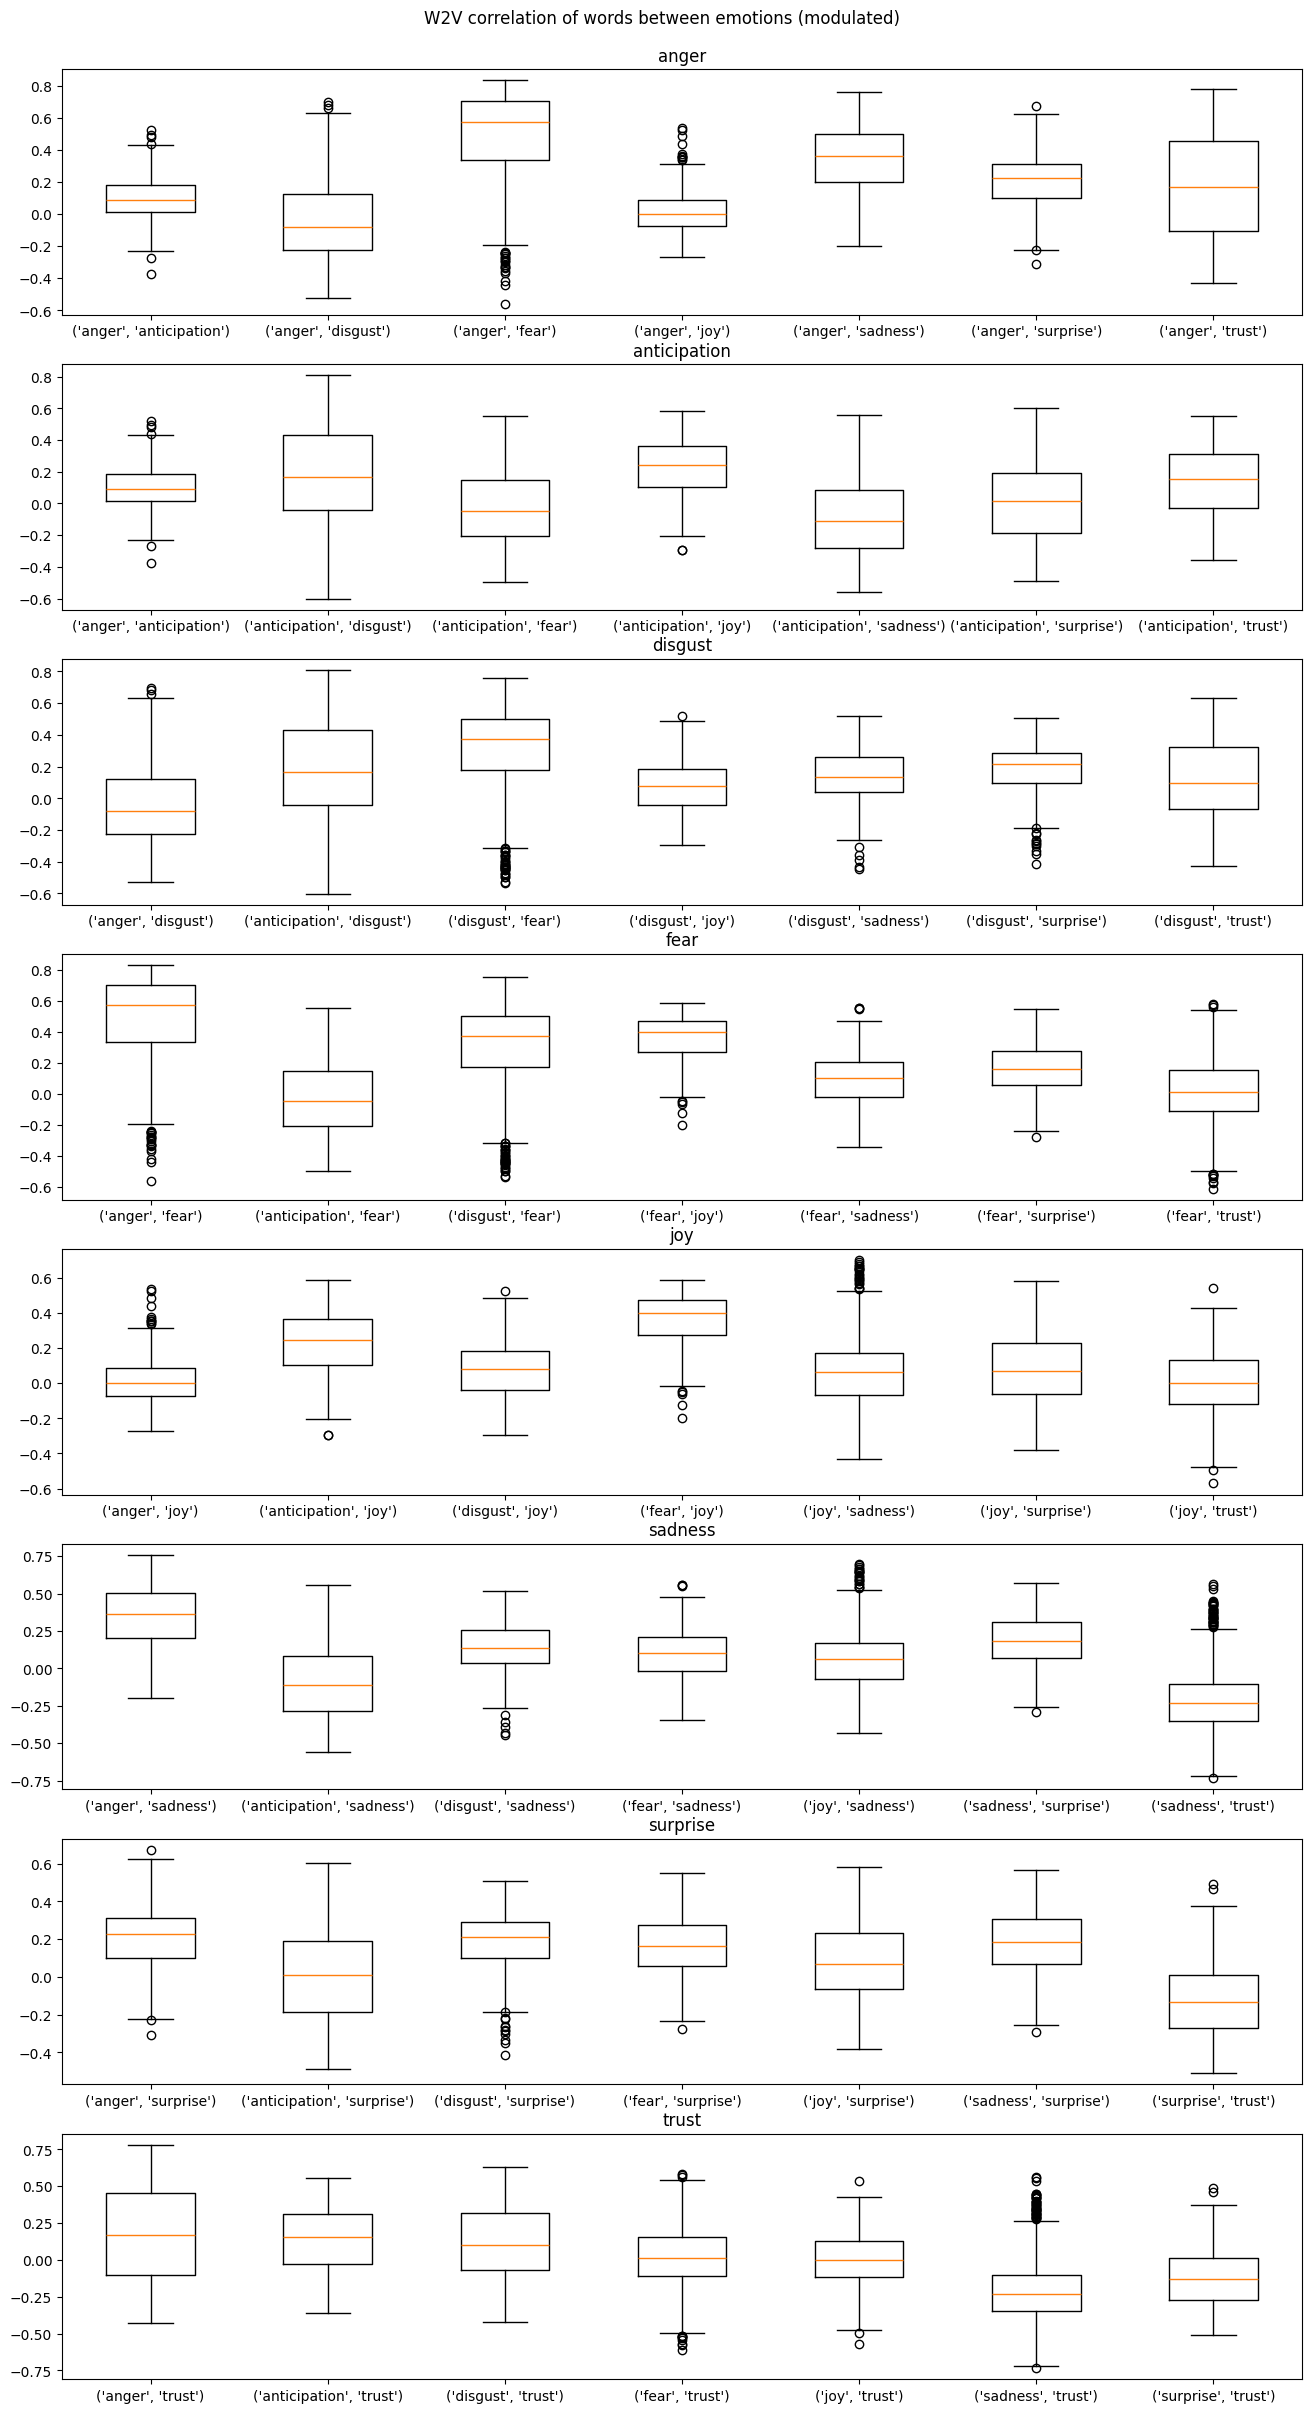

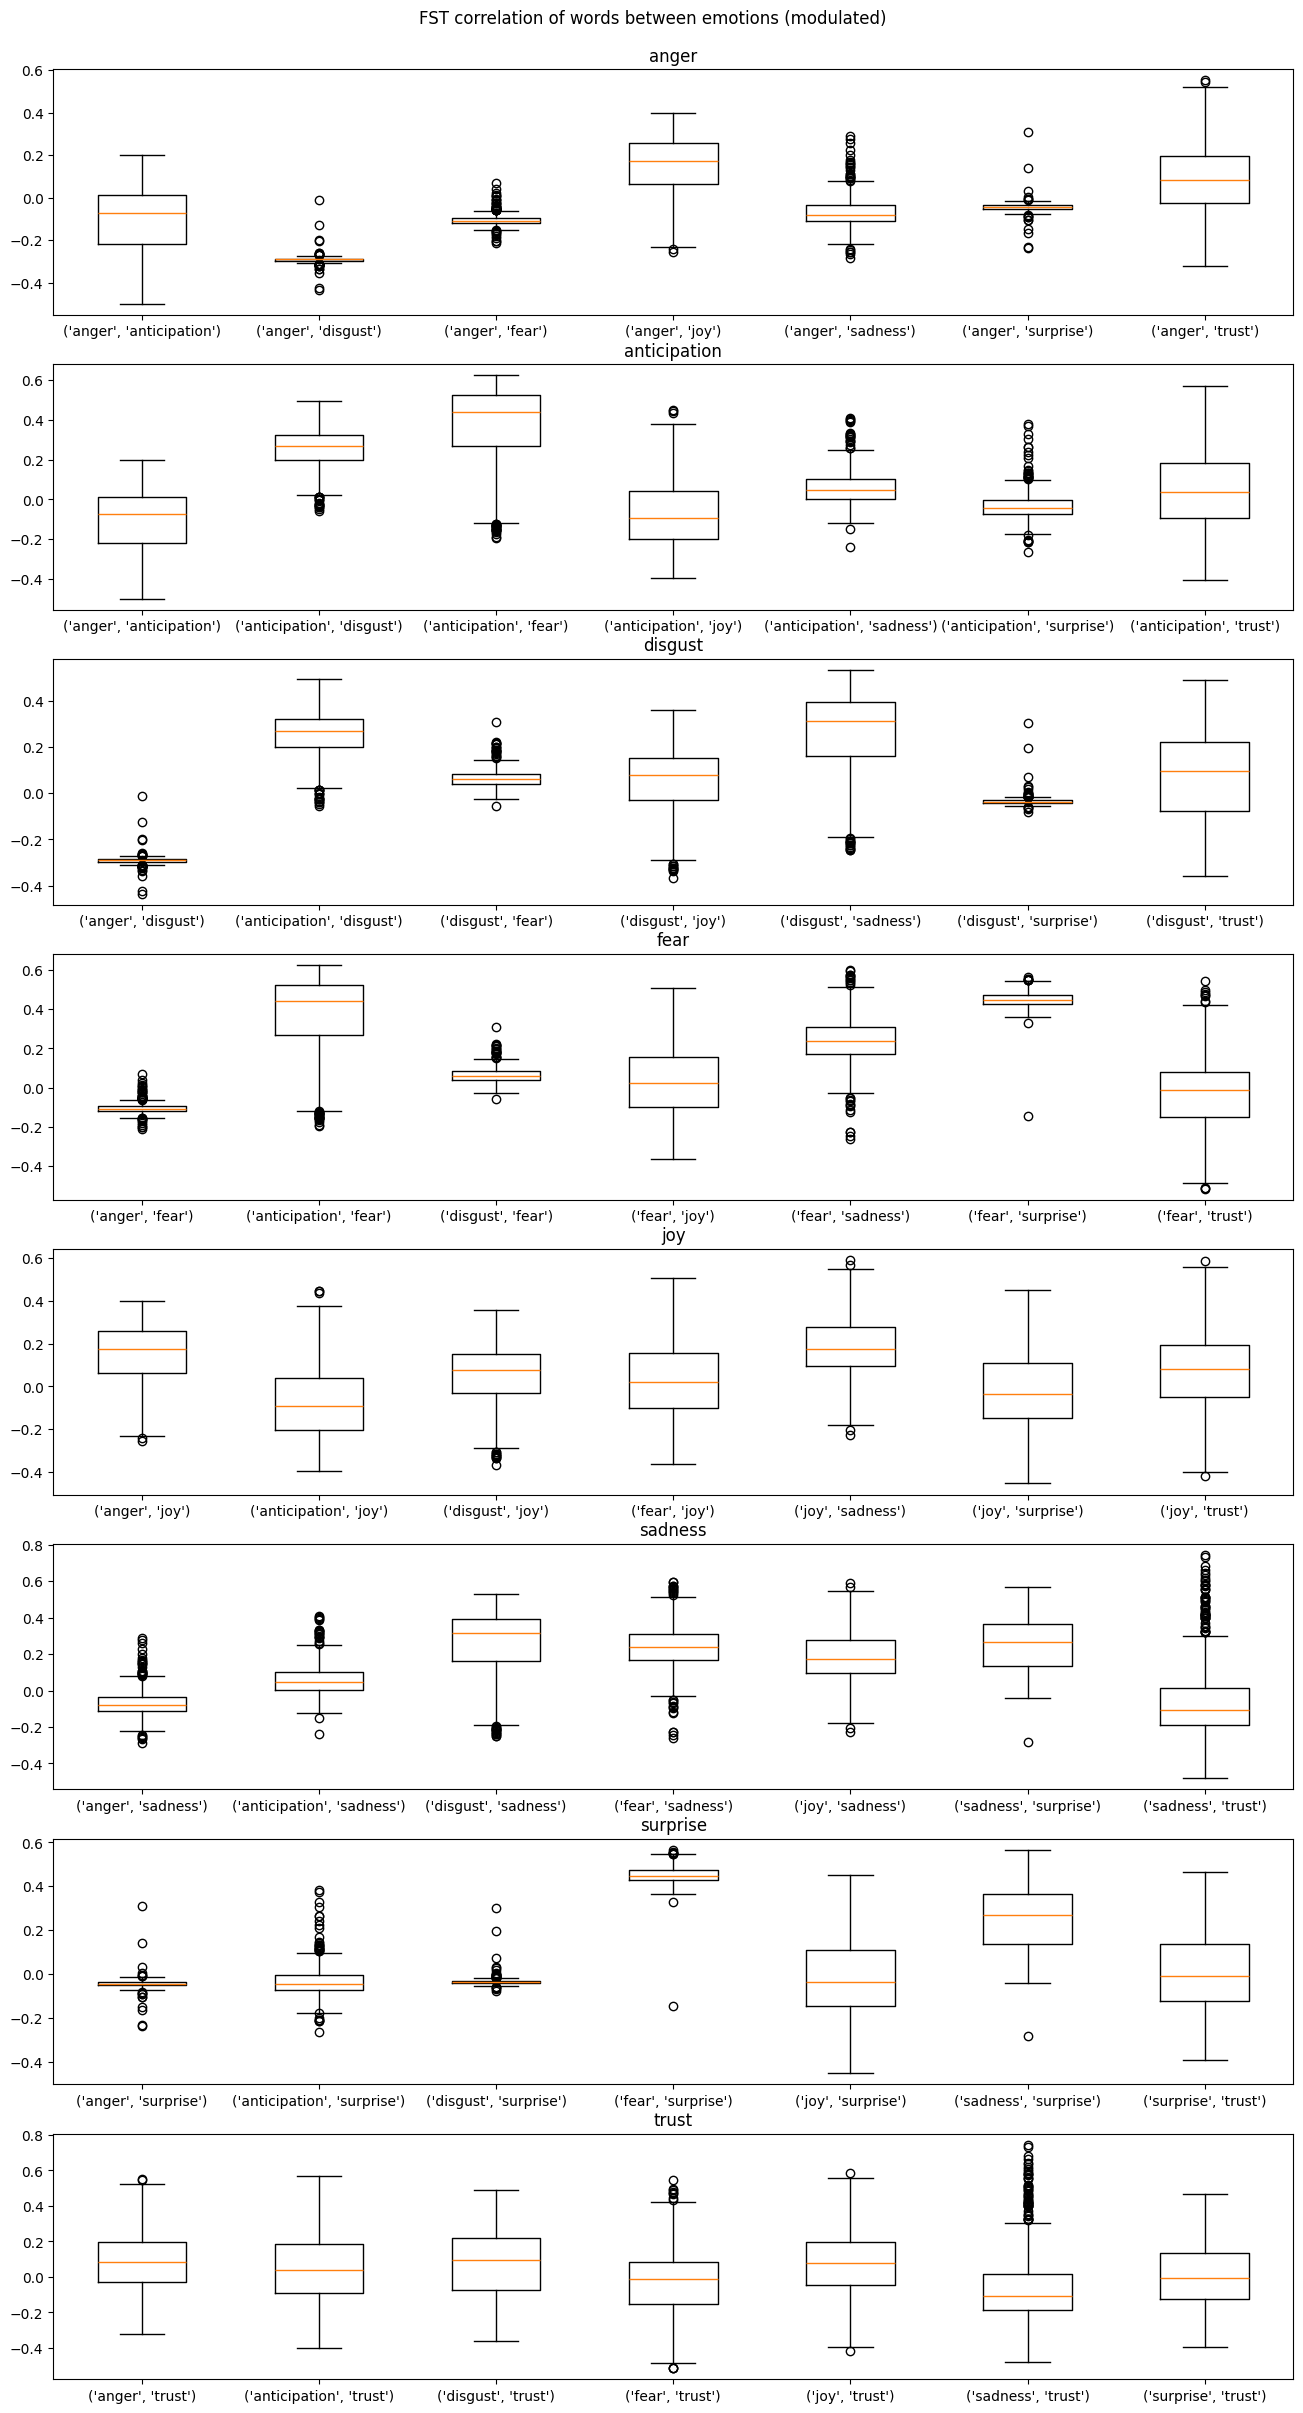

In [34]:
box_plot_word_info(words_embbed_w2v_mod,"W2V correlation of words between emotions (modulated)")
box_plot_word_info(words_embbed_fst_mod,"FST correlation of words between emotions (modulated)")

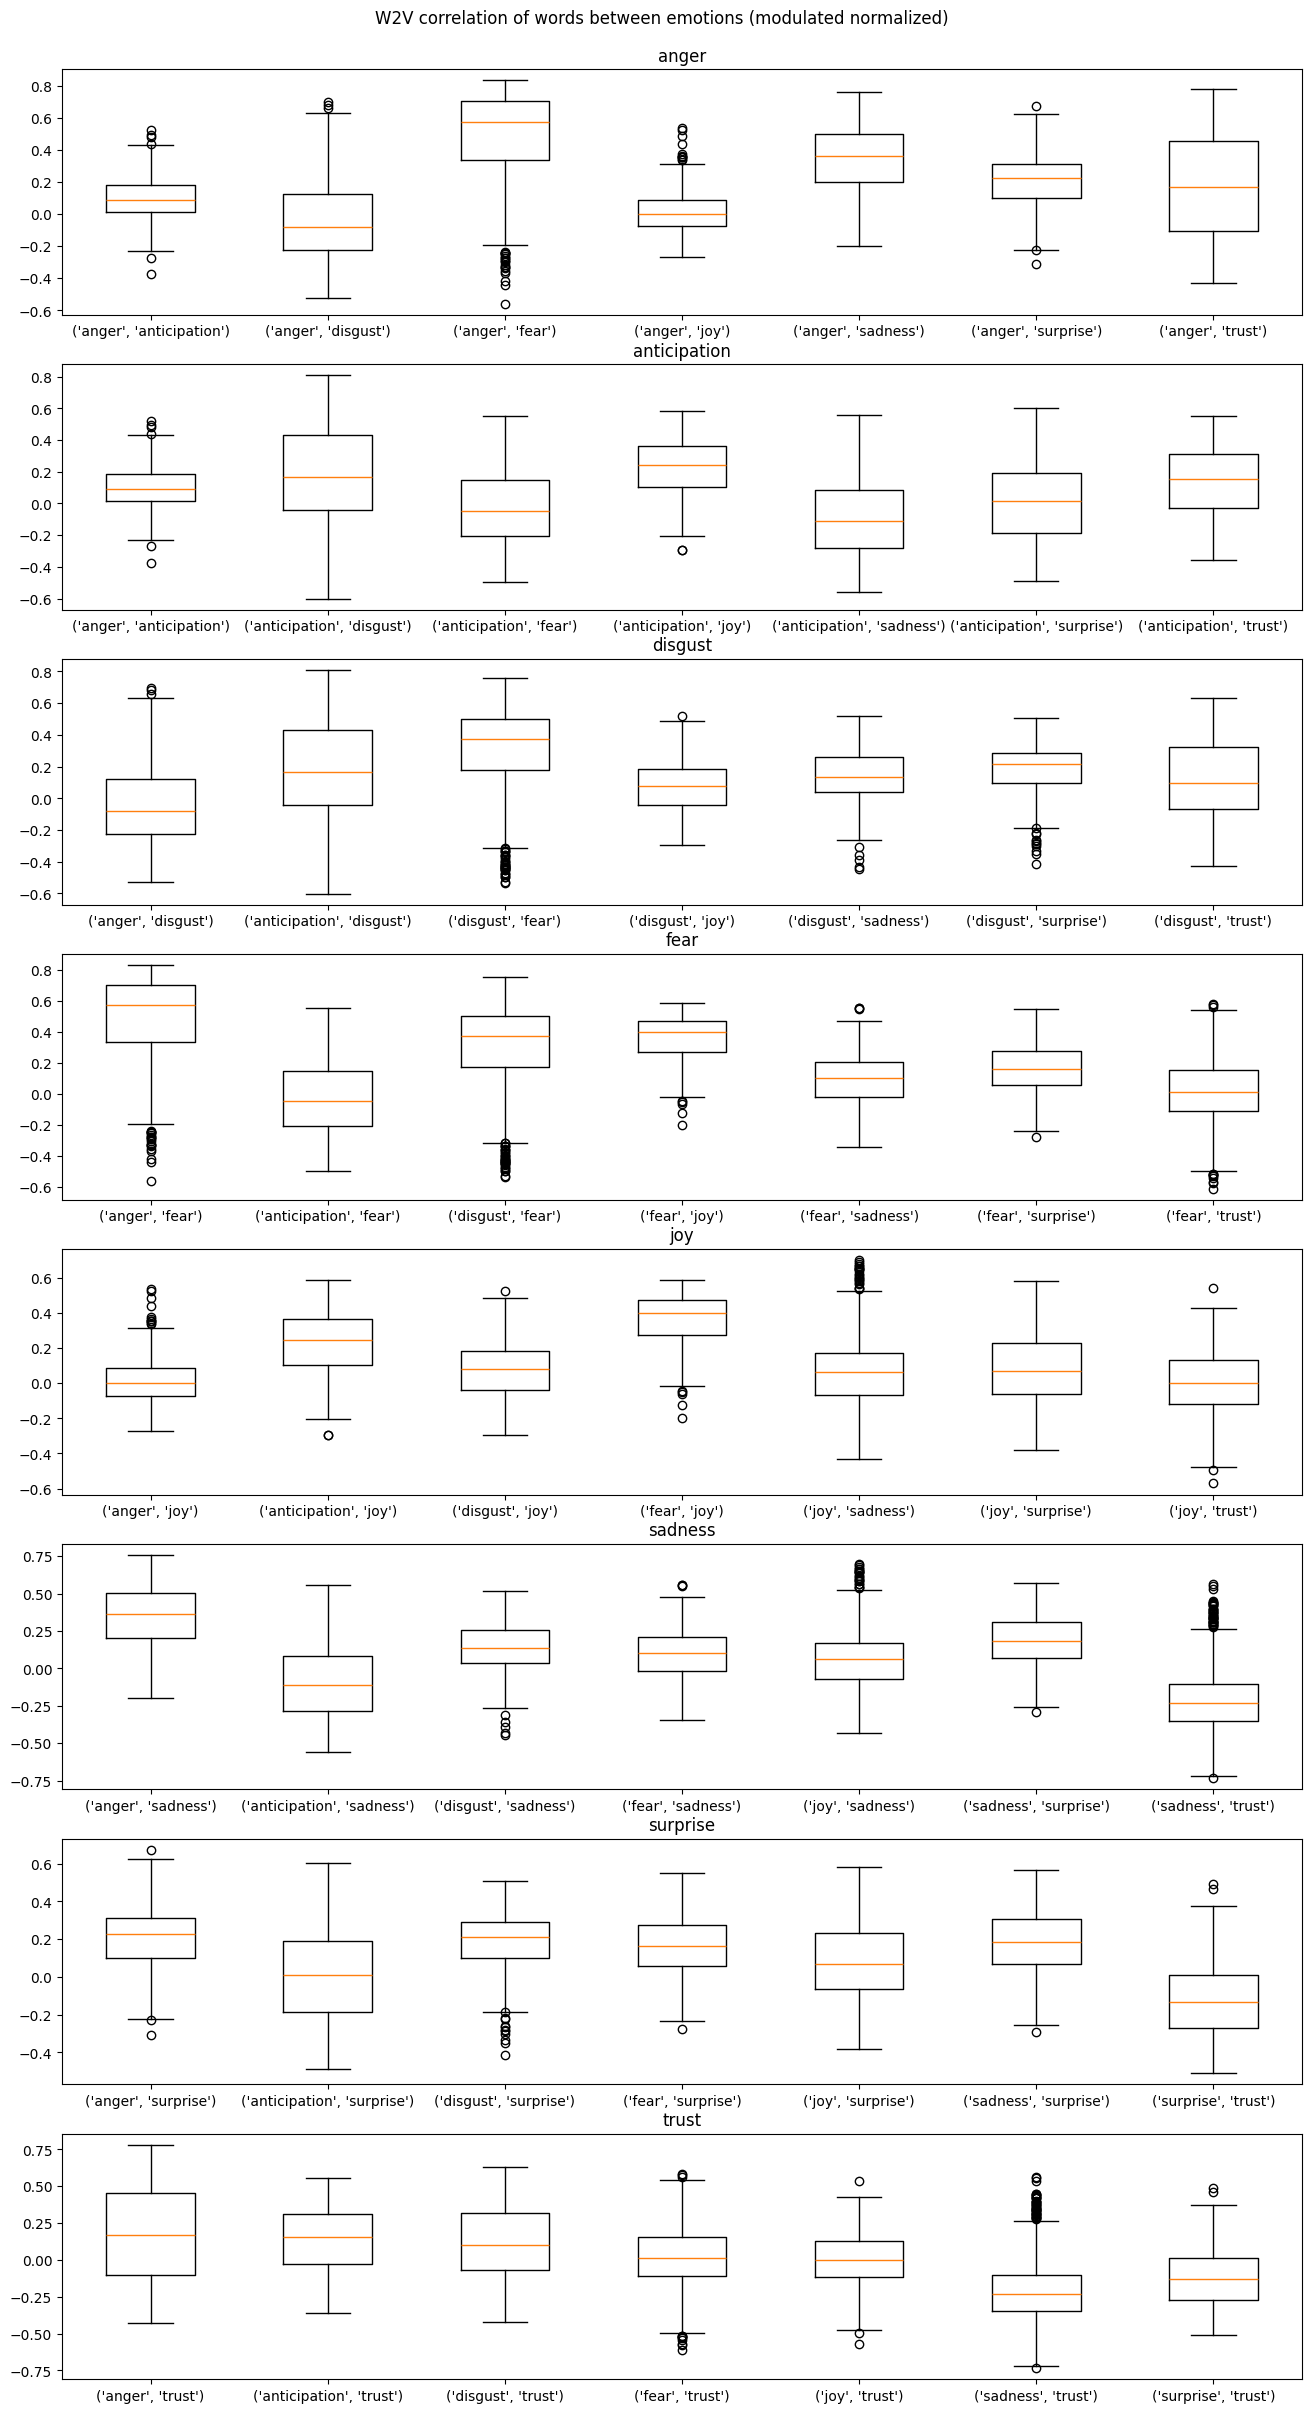

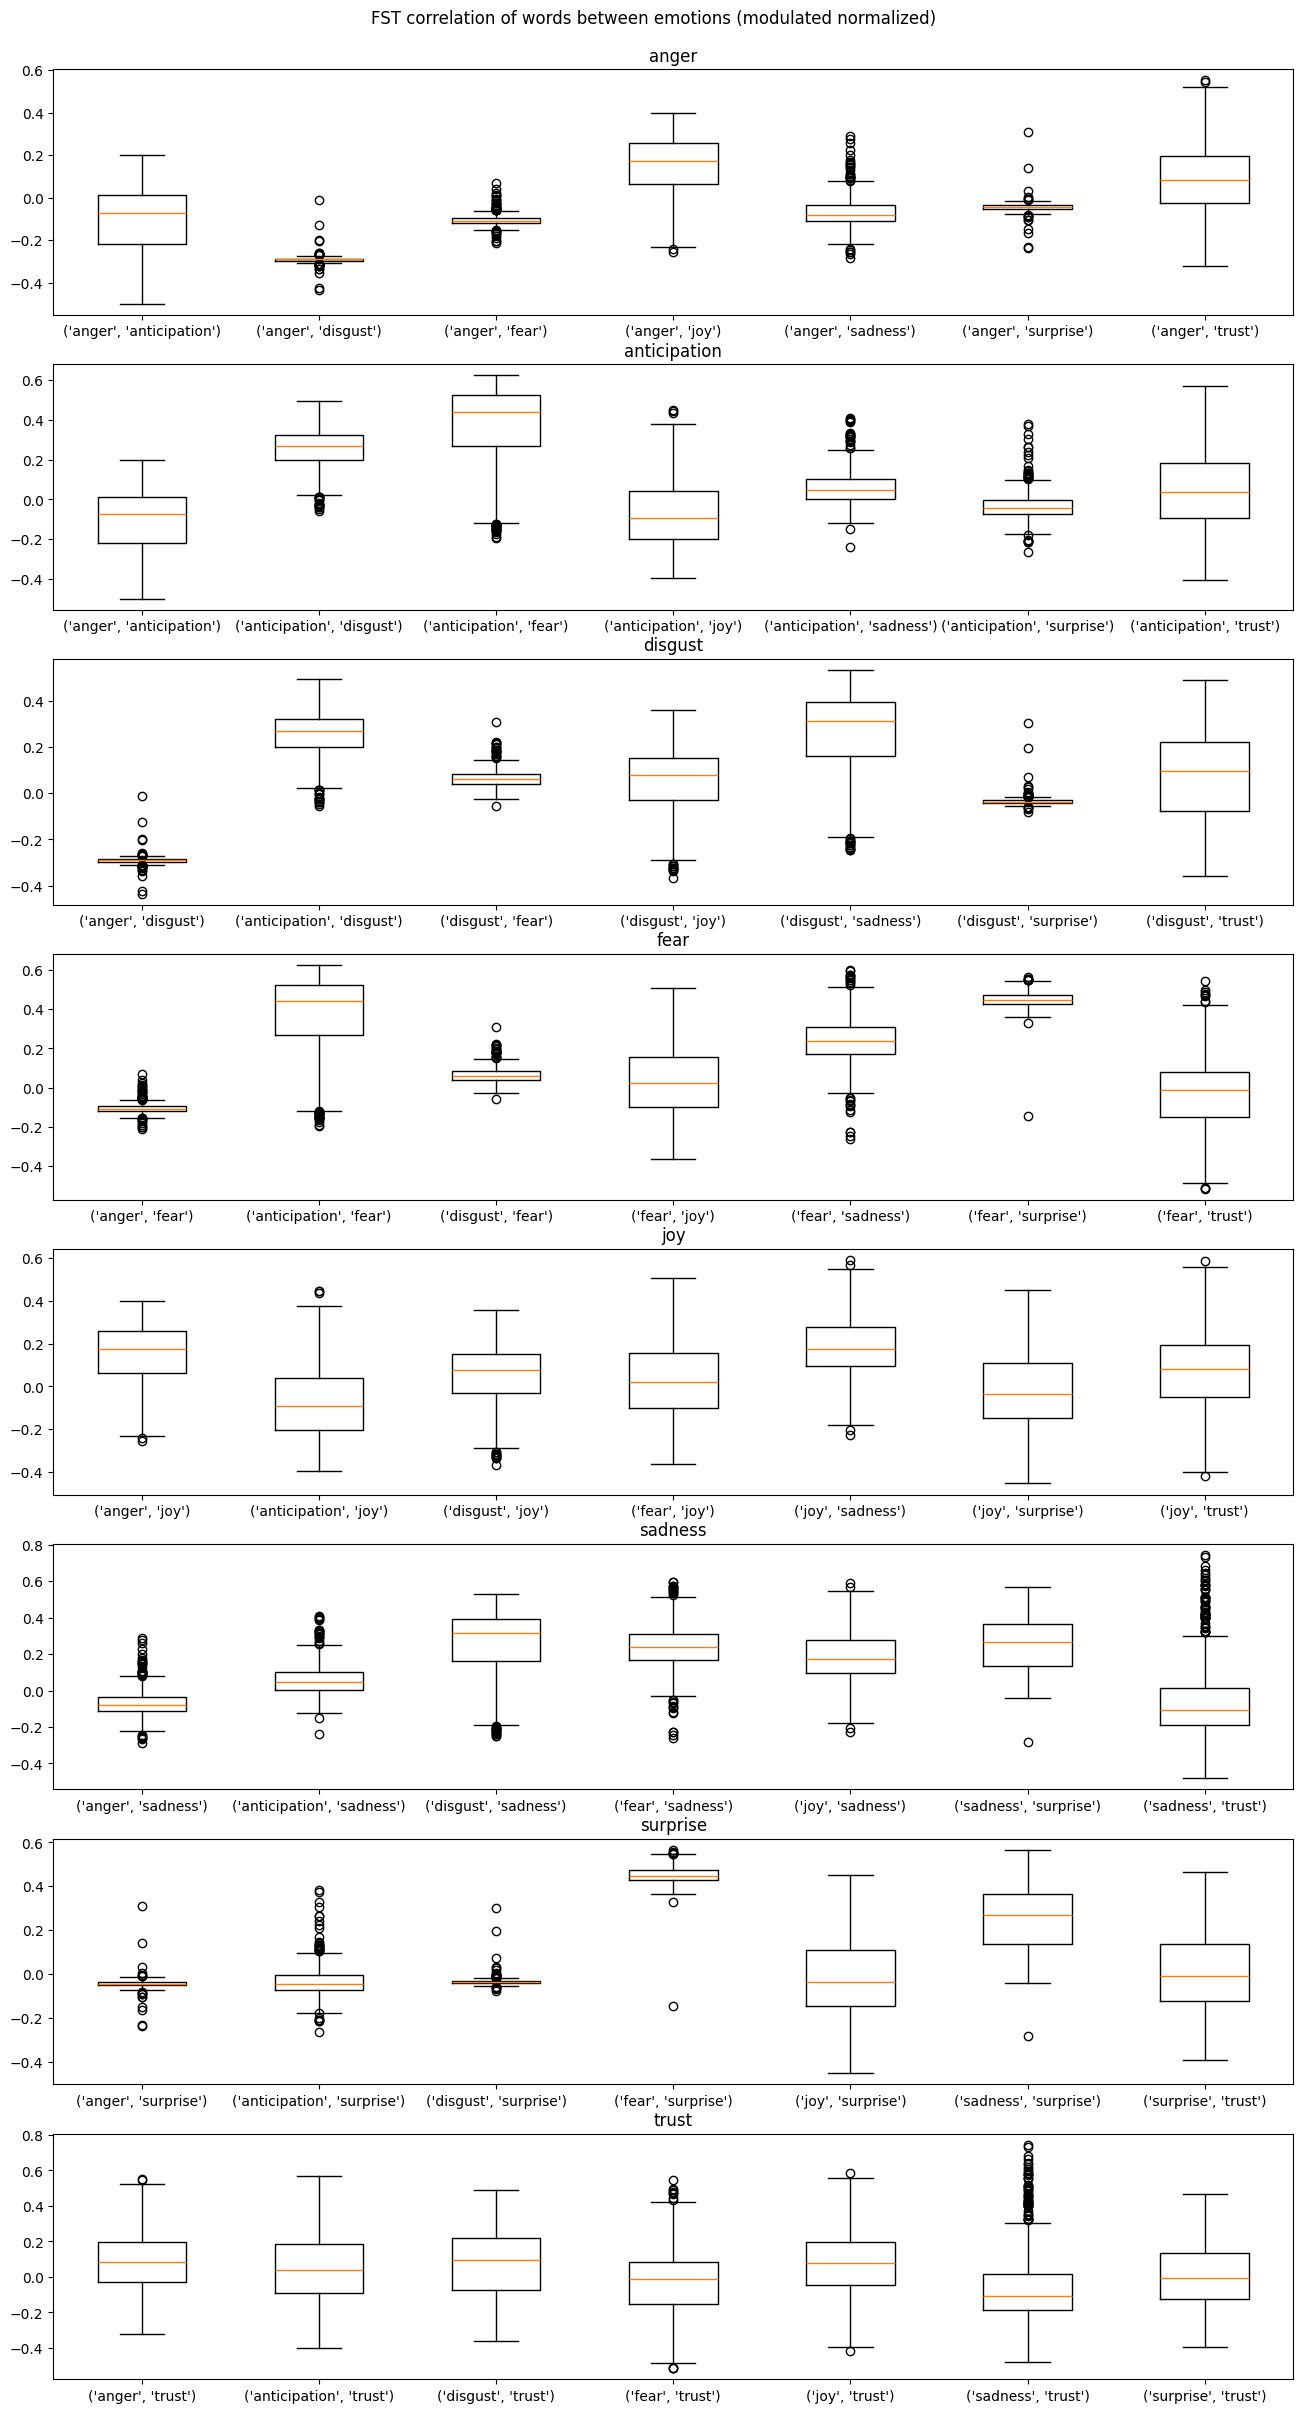

In [35]:
box_plot_word_info(words_embbed_w2v_mod_norm,"W2V correlation of words between emotions (modulated normalized)")
box_plot_word_info(words_embbed_fst_mod_norm,"FST correlation of words between emotions (modulated normalized)")

## Uso de la frecuencia maxima para la modulacion de palabras

0.0


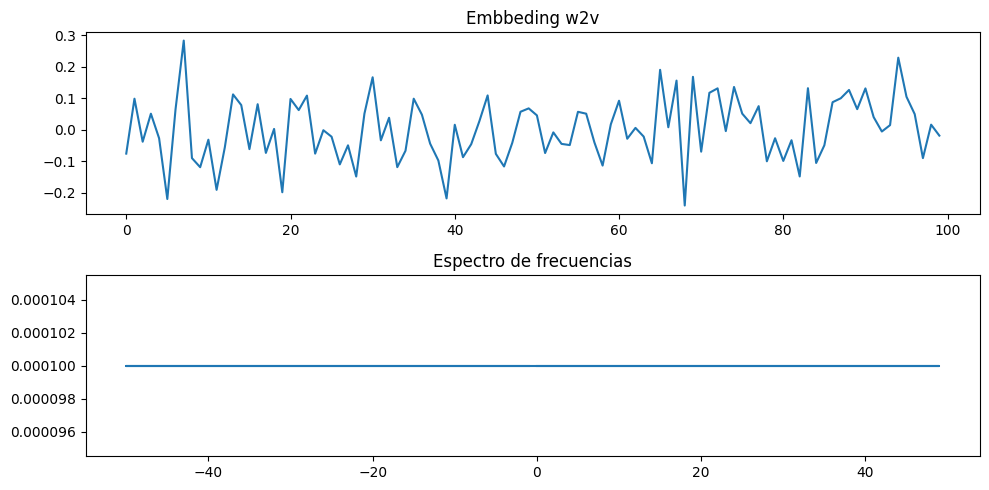

In [36]:
#Obtencion de espectro con MESA
from memspectrum import MESA

word = poems_w2v["anger"].wv.get_vector("for",norm=True)

M = MESA()
M.solve(word)
frecuencies,spectrum = M.spectrum(1/len(word))

fig,ax = plt.subplots(2,figsize=(10,5))

ax[0].set_title("Embbeding w2v")
ax[0].plot(word)

ax[1].set_title("Espectro de frecuencias")
ax[1].plot(frecuencies,spectrum)
fig.tight_layout()
print(frecuencies[np.argmax(spectrum)])

14.0


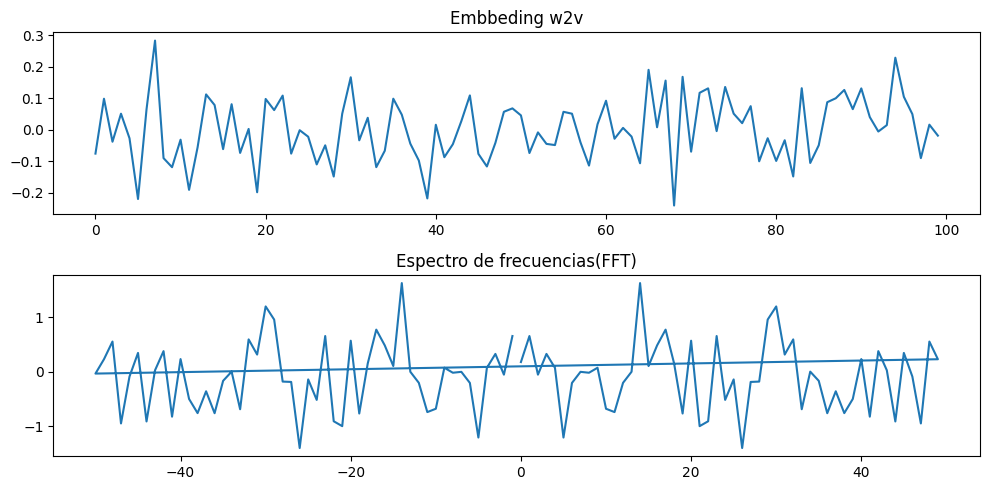

In [37]:
#Obtencion de espectro con numpy
sp = np.fft.fft(word)
freq = np.fft.fftfreq(len(word),d=1/len(word))

fig,ax = plt.subplots(2,figsize=(10,5))

ax[0].set_title("Embbeding w2v")
ax[0].plot(word)

ax[1].set_title("Espectro de frecuencias(FFT)")
ax[1].plot(freq,sp.real)
fig.tight_layout()

print(freq[np.argmax(sp.real)])

In [38]:
def get_max_freq(models,emotion_list,solver="maxent"):
    """Obtiene las frecuencias maximas de los espectros con maxent o numpy"""

    #Crea un diccionario con la llaver igual a las emociones y los valores igual a listas
    frequencies_dir = {}
    for emotion in emotion_list:
        frequencies_dir[emotion] = []

        words = models[emotion].wv.key_to_index.keys()

        M = MESA()
        for word in words:
            #Saca el vector de la palabra
            vector = models[emotion].wv.get_vector(word,norm=True)
            if solver == "maxent":
                #Calcula el espectro en frecuencia con maxen
                M.solve(vector)
                frecuencies,spectrum = M.spectrum(1/len(vector))
                freq = frecuencies[np.argmax(spectrum[len(vector)//2:])]
            elif solver == "np":
                #Calcula es espectro en frecuencia con numpy
                spectrum = np.fft.fft(vector)
                frecuencies = np.fft.fftfreq(len(vector),d=1/len(vector))
                freq = frecuencies[np.argmax(spectrum.real[len(vector)//2:])]
            frequencies_dir[emotion].append(freq)
    return frequencies_dir

In [39]:
freq_fst_maxent = get_max_freq(poems_fst,emotion_list)
freq_fst_np = get_max_freq(poems_fst,emotion_list,"np")

freq_w2v_maxent = get_max_freq(poems_w2v,emotion_list)
freq_w2v_np = get_max_freq(poems_w2v,emotion_list,"np")

[3.292419825072886, 2.732628593528426, 5.090008009611534, 2.850852949585438, 3.4056867225184058, 4.945, 2.8971153846153848, 2.601808615586978]
[49.0, 48.35871657754011, 48.98951612903226, 48.75073673870334, 41.755941681645695, 48.360400899979545, 49.0, 46.06849100860047]


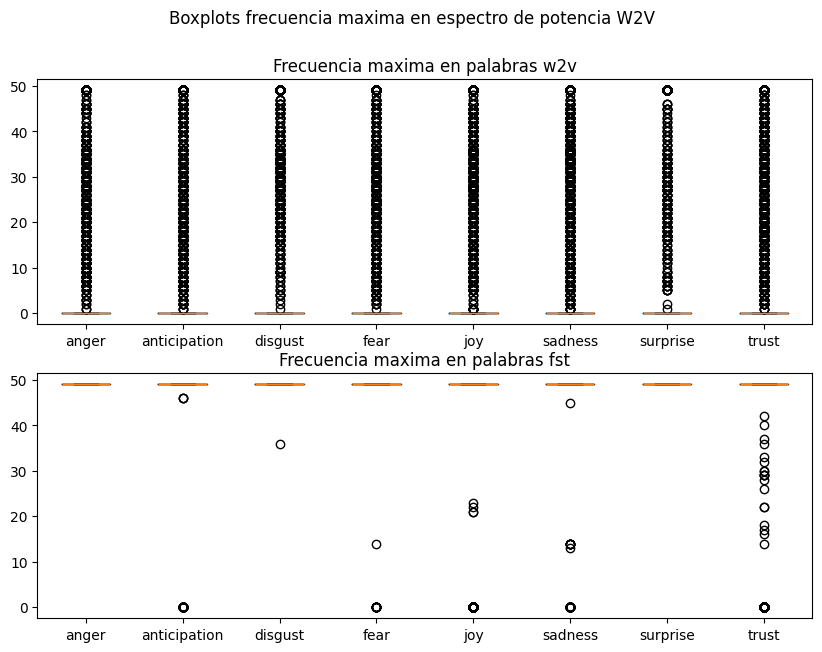

In [40]:
fig,ax = plt.subplots(2,figsize=(10,7))

fig.suptitle("Boxplots frecuencia maxima en espectro de potencia W2V")
labels = [label for label in freq_w2v_maxent.keys()]
data = [freq_w2v_maxent[label] for label in labels]
ax[0].boxplot(data)
ax[0].set_xticklabels(labels)
ax[0].set_title("Frecuencia maxima en palabras w2v")
medias_freq_spec_w2v = [np.mean(data[i]) for i in range(len(data))]
print(medias_freq_spec_w2v)

labels = [label for label in freq_fst_maxent.keys()]
data = [freq_fst_maxent[label] for label in labels]
ax[1].boxplot(data)
ax[1].set_xticklabels(labels)
ax[1].set_title("Frecuencia maxima en palabras fst")

medias_freq_spec_fst = [np.mean(data[i]) for i in range(len(data))]
print(medias_freq_spec_fst)

[31.471574344023324, 21.204159683726527, 31.857629154985982, 32.052463547126656, 29.815604637386816, 31.118235294117646, 27.37046703296703, 30.08605721802039]
[12.494880546075086, 44.23058823529412, 12.0, 13.679027504911591, 44.547833033752745, 16.53569237062794, 46.80520833333333, 27.001876465989053]


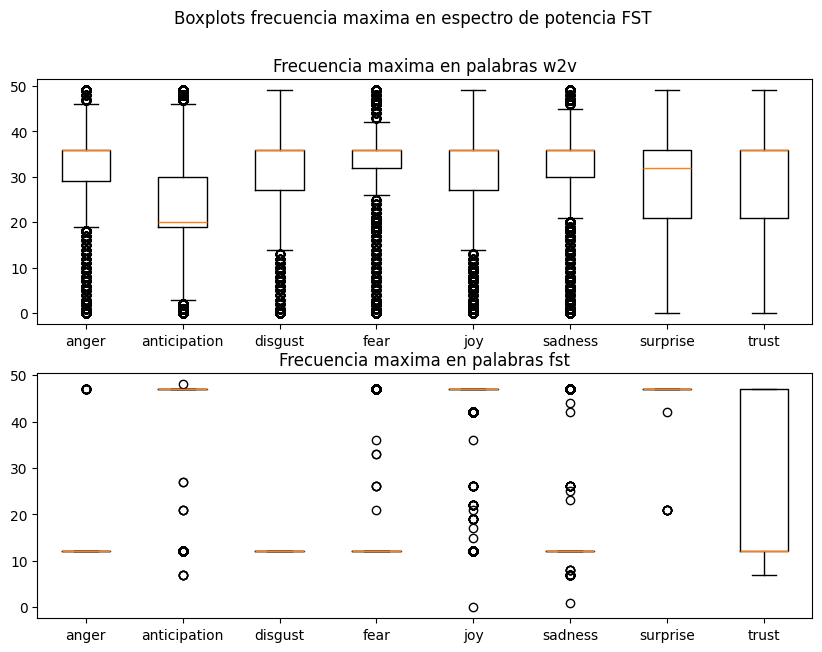

In [41]:
fig,ax = plt.subplots(2,figsize=(10,7))

fig.suptitle("Boxplots frecuencia maxima en espectro de potencia FST")
labels = [label for label in freq_w2v_np.keys()]
data = [freq_w2v_np[label] for label in labels]
ax[0].boxplot(data)
ax[0].set_xticklabels(labels)
ax[0].set_title("Frecuencia maxima en palabras w2v")
medias_freq_spec_w2v = [np.mean(data[i]) for i in range(len(data))]
print(medias_freq_spec_w2v)

labels = [label for label in freq_fst_np.keys()]
data = [freq_fst_np[label] for label in labels]
ax[1].boxplot(data)
ax[1].set_xticklabels(labels)
ax[1].set_title("Frecuencia maxima en palabras fst")

medias_freq_spec_fst = [np.mean(data[i]) for i in range(len(data))]
print(medias_freq_spec_fst)

## Prueba de correlacion

In [42]:
#Con los datos calculados obtenemos la media de cada clase
data = [freq_fst_maxent[label] for label in labels]
mean_fst_maxent = [np.mean(data[i]) for i in range(len(data))]

data = [freq_w2v_maxent[label] for label in labels]
mean_w2v_maxent = [np.mean(data[i]) for i in range(len(data))]

data = [freq_fst_np[label] for label in labels]
mean_fst_np = [np.mean(data[i]) for i in range(len(data))]

data = [freq_w2v_np[label] for label in labels]
mean_w2v_np = [np.mean(data[i]) for i in range(len(data))]

display(mean_fst_maxent,mean_w2v_maxent,mean_fst_np,mean_w2v_np)

[49.0,
 48.35871657754011,
 48.98951612903226,
 48.75073673870334,
 41.755941681645695,
 48.360400899979545,
 49.0,
 46.06849100860047]

[3.292419825072886,
 2.732628593528426,
 5.090008009611534,
 2.850852949585438,
 3.4056867225184058,
 4.945,
 2.8971153846153848,
 2.601808615586978]

[12.494880546075086,
 44.23058823529412,
 12.0,
 13.679027504911591,
 44.547833033752745,
 16.53569237062794,
 46.80520833333333,
 27.001876465989053]

[31.471574344023324,
 21.204159683726527,
 31.857629154985982,
 32.052463547126656,
 29.815604637386816,
 31.118235294117646,
 27.37046703296703,
 30.08605721802039]

In [44]:
def scale(x):
    """Escala entre 0 y 1 los valores de x"""
    return (x-np.min(x))/(np.max(x)-np.min(x))

In [45]:
#Escalamos entre 0 y 1 los valores medios de las frecuencias
mean_fst_maxent = scale(mean_fst_maxent)
mean_w2v_maxent = scale(mean_w2v_maxent)
mean_fst_np = scale(mean_fst_np)
mean_w2v_np = scale(mean_w2v_np)

display(mean_fst_maxent,mean_w2v_maxent,mean_fst_np,mean_w2v_np)

array([1.        , 0.91147456, 0.99855276, 0.96559066, 0.        ,
       0.91170707, 1.        , 0.59532228])

array([0.27755461, 0.05257616, 1.        , 0.10009018, 0.32307624,
       0.94172171, 0.11868292, 0.        ])

array([0.01421858, 0.92602773, 0.        , 0.0482407 , 0.9351426 ,
       0.13031648, 1.        , 0.4310239 ])

array([0.94645345, 0.        , 0.98204011, 1.        , 0.79380565,
       0.91388255, 0.56841212, 0.81873606])

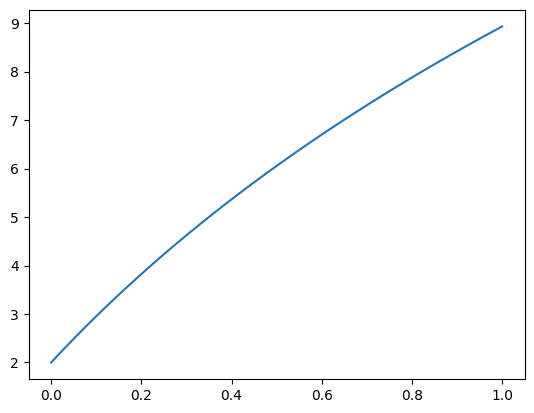

In [46]:
#Usaremos la siguiente funcion para boostear las diferencias entre la frecuencias
x = np.linspace(0,1,100)
y = 10*np.log(1+x) + 2
plt.plot(x,y)

In [47]:
#Usaremos primero maxent
frecuencies_fst = mean_fst_maxent.copy()
frecuencies_fst = 10*np.log(1 + frecuencies_fst) + 2

frecuencies_w2v = mean_w2v_maxent.copy()
frecuencies_w2v = 10*np.log(1 + frecuencies_w2v)

print("FastText freq: ",frecuencies_fst)
print("w2v freq",frecuencies_w2v)

FastText freq:  [8.93147181 8.47874967 8.924233   8.75792791 2.         8.47996599
 8.93147181 6.67075773]
w2v freq [2.44947789 0.51240648 6.93147181 0.95392161 2.79959511 6.63575058
 1.12152029 0.        ]


In [48]:
emotion_carrier_frecuencies_fst = {}
emotion_carrier_frecuencies_w2v = {}
for emotion,i in zip(emotion_list,range(8)):
    emotion_carrier_frecuencies_fst[emotion] = frecuencies_fst[i]
    emotion_carrier_frecuencies_w2v[emotion] = frecuencies_w2v[i]

display(emotion_carrier_frecuencies_w2v,emotion_carrier_frecuencies_fst)

{'anger': 2.44947788815791,
 'anticipation': 0.5124064824300384,
 'disgust': 6.931471805599453,
 'fear': 0.9539216146783323,
 'joy': 2.7995951078937265,
 'sadness': 6.63575058103783,
 'surprise': 1.121520288183776,
 'trust': 0.0}

{'anger': 8.931471805599454,
 'anticipation': 8.478749671362777,
 'disgust': 8.924233000015743,
 'fear': 8.757927907899548,
 'joy': 2.0,
 'sadness': 8.479965992800018,
 'surprise': 8.931471805599454,
 'trust': 6.670757733271237}

In [50]:
def create_correlation_df_mod_per_emotion(models,emotion_list,words_intersection,frecuencies,norm = False):
    """
    Crea un dataframe de correlacion entre palabras con la frecuencia maxima promedio de cada emocion como
    frecuencia de la carrier
    """
    emotion_combinations = list(combinations(emotion_list,2))

    words_embbed_info = {}
    words_embbed_info["words"] = list(words_intersection)

    for emotion in emotion_list:
        words_embbed_info["f_"+emotion] = []

    for comb in emotion_combinations:
        words_embbed_info["P_"+str(comb)] = []

    for word in words_intersection:
        #Añadimos la frecuencia por cada emoción
        for emotion in emotion_list:
            words_embbed_info["f_"+emotion].append(freq_dict[emotion][word])

        #Calculamos la correlacion pearson para cada par de emociones.    
        for comb in emotion_combinations:
            emotion_a = comb[0]
            emotion_b = comb[1]

            embbeding_a = models[emotion_a].wv.get_vector(word,norm=True)
            embbeding_b = models[emotion_b].wv.get_vector(word,norm=True)

            fm_embbed_a = modulate(embbeding_a,frecuencies[emotion_a],1000,1/len(embbeding_a),1)
            fm_embbed_b = modulate(embbeding_b,frecuencies[emotion_b],1000,1/len(embbeding_b),1)
            
            if norm:
                fm_embbed_a = fm_embbed_a/np.linalg.norm(fm_embbed_a)
                fm_embbed_b = fm_embbed_b/np.linalg.norm(fm_embbed_b)


            words_embbed_info["P_"+str(comb)].append(pearsonr(fm_embbed_a,fm_embbed_b))

    return pd.DataFrame(words_embbed_info)

In [51]:
mod_per_emotion_info_w2v = create_correlation_df_mod_per_emotion(poems_w2v,emotion_list,words_intersection,emotion_carrier_frecuencies_w2v,norm=True)
mod_per_emotion_info_fst = create_correlation_df_mod_per_emotion(poems_fst,emotion_list,words_intersection,emotion_carrier_frecuencies_fst,norm=True)

display(mod_per_emotion_info_w2v,mod_per_emotion_info_fst)

,words,f_anger,f_anticipation,f_disgust,f_fear,f_joy,f_sadness,f_surprise,f_trust,"P_('anger', 'anticipation')",...,"P_('fear', 'joy')","P_('fear', 'sadness')","P_('fear', 'surprise')","P_('fear', 'trust')","P_('joy', 'sadness')","P_('joy', 'surprise')","P_('joy', 'trust')","P_('sadness', 'surprise')","P_('sadness', 'trust')","P_('surprise', 'trust')"
0,someone,9,31,9,26,33,37,10,33,"(0.012075331852180956, 0.9050856269828085)",...,"(0.023438450772031827, 0.8169500764683668)","(-0.04543179291458831, 0.6535485939232856)","(-0.04224819330432461, 0.6764175080626981)","(-0.0012625395099267831, 0.990053297558088)","(0.11994470788933886, 0.23457196213497786)","(-0.33143753126617415, 0.0007559351334985839)","(0.12257597453741452, 0.22439036148389346)","(0.07529727645008336, 0.4565353780728062)","(0.22064824745265094, 0.027383566576359663)","(0.08361205895600128, 0.4082041652684703)"
1,stood,25,106,19,94,76,88,17,109,"(-0.024737497070092138, 0.8069967555417003)",...,"(0.1568345167099784, 0.1191651866927576)","(0.029157054066684417, 0.7733727622693404)","(0.109434284350662, 0.2784343008502445)","(0.13295211818964797, 0.1872800538648839)","(0.4168396849905018, 1.602901099462391e-05)","(-0.070085285236641, 0.4883760081774209)","(0.16225064363341565, 0.10678503005733689)","(0.0856921896362686, 0.396600035721487)","(0.25988734253579254, 0.00902171601218616)","(0.005852765405788182, 0.9539140691521812)"
2,rough,17,18,5,19,19,30,8,17,"(-0.13576621182241616, 0.17803236294738786)",...,"(0.11239262887464854, 0.26556777486052446)","(-0.05641948360523329, 0.5771545029633345)","(0.19375922351874508, 0.053411489393039975)","(0.109925533148607, 0.276269321098129)","(0.24059609847110228, 0.01589817517683593)","(-0.10641101869126175, 0.29200796308774646)","(0.23940093299993734, 0.016444177930977015)","(-0.010207423354042768, 0.9197143707757303)","(0.2244778479094008, 0.024749343758702906)","(-0.374942103161283, 0.00012130183704489334)"
3,think,64,173,36,123,203,148,19,245,"(0.22691804874749705, 0.023186121950839675)",...,"(0.13435762271311105, 0.1826185485978575)","(0.10288015059129053, 0.3084058829815852)","(0.3872446818769496, 6.885204776374295e-05)","(0.05020207027178714, 0.6198788848256479)","(0.273580661976933, 0.005884254729093612)","(-0.12497048715117316, 0.21539876906916372)","(-0.16802499583515618, 0.0947161761792853)","(0.16168167541091244, 0.10803637159031289)","(-0.08110189881052855, 0.4224690584157621)","(0.4453237059381229, 3.4410271971683246e-06)"
4,thousand,16,55,9,47,63,50,6,77,"(-0.0670926883340031, 0.5071771303252693)",...,"(0.15876525882449585, 0.11463077338714117)","(0.04428883691986332, 0.661723426405004)","(0.10804339668659867, 0.2846255935758705)","(0.10106788637505591, 0.31705076363913925)","(0.081015514811177, 0.42296502994027874)","(0.4223474114397374, 1.2032719098357201e-05)","(0.2601413236844877, 0.008952215264190865)","(0.015099498851730987, 0.8814707082183697)","(0.29650687582367274, 0.0027403334470539084)","(-0.04826404698715771, 0.6334685578618697)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
557,singing,13,48,6,31,101,45,13,52,"(-0.021920996481301077, 0.8286136505336601)",...,"(0.1729875530646289, 0.08522763255028037)","(-0.0629004648645557, 0.5341308699143827)","(0.09586265120307949, 0.3427419300418159)","(-0.026495087626950766, 0.7935791725958724)","(0.23685401186215865, 0.017662058256900003)","(0.00024721116224355605, 0.9980523412055553)","(0.13836465121952482, 0.16979464537237438)","(0.018207917557305997, 0.8573057531180426)","(0.2659173183105391, 0.007493738738520684)","(-0.1873797533573711, 0.06192803802464215)"
558,heart,123,423,43,275,797,568,58,471,"(0.19095608966672972, 0.0570268871294117)",...,"(-0.1868133418511219, 0.0627348626793441)","(-0.045409038891322695, 0.6537109442351412)","(0.2145621514690043, 0.03205865216797289)","(-0.0032353577811045425, 0.9745144032467598)","(-0.12343602243775048, 0.2211308989641397)","(0.12988564911045258, 0.19774934668073224)","(-0.

,words,f_anger,f_anticipation,f_disgust,f_fear,f_joy,f_sadness,f_surprise,f_trust,"P_('anger', 'anticipation')",...,"P_('fear', 'joy')","P_('fear', 'sadness')","P_('fear', 'surprise')","P_('fear', 'trust')","P_('joy', 'sadness')","P_('joy', 'surprise')","P_('joy', 'trust')","P_('sadness', 'surprise')","P_('sadness', 'trust')","P_('surprise', 'trust')"
0,someone,9,31,9,26,33,37,10,33,"(-0.09739288411921868, 0.335056837077572)",...,"(-0.10686177207328941, 0.28995690444923594)","(0.17808922632501425, 0.07627813109093924)","(-0.1047683564384249, 0.2995636000998856)","(0.08312753572565908, 0.41093542035161995)","(0.21838072947663884, 0.02905280397435544)","(0.30168785807597887, 0.0022857120896087905)","(0.034797678647064324, 0.7310674158336689)","(0.17752227689706696, 0.07723378312101957)","(0.06857606337231548, 0.49781123930489807)","(-0.002609113144880479, 0.979446261061203)"
1,stood,25,106,19,94,76,88,17,109,"(-0.3349665019133208, 0.0006579667192629765)",...,"(0.11039624044639161, 0.27420549989868565)","(0.07135507392371375, 0.48051180156508416)","(0.02449199472433945, 0.8088754950506715)","(-0.03435994464922067, 0.7343236429648972)","(-0.13936742553965717, 0.16669200670167011)","(0.07310571654311834, 0.46978188795310816)","(0.10624558125452292, 0.29276315324902474)","(0.1783651404969309, 0.07581649647072225)","(0.24796039776488146, 0.012867868662540765)","(0.029716480039355377, 0.7691449484044044)"
2,rough,17,18,5,19,19,30,8,17,"(-0.31916700022327504, 0.0012094843042068854)",...,"(-0.08891571363300141, 0.37900972011083534)","(0.03155481607977781, 0.7553000239960933)","(0.03339919826576852, 0.7414869090775)","(0.13181428304668588, 0.1911167013046362)","(-0.030921786532024813, 0.7600590308155022)","(0.09869818577986879, 0.32858847855817197)","(-0.22795001319307126, 0.022550882823864114)","(0.15259200880900203, 0.12961392169920166)","(-0.1466803414747592, 0.14532320189478937)","(-0.007544908918878719, 0.9406113021250554)"
3,think,64,173,36,123,203,148,19,245,"(0.07022279338353227, 0.4875210906468462)",...,"(-0.01900064600656085, 0.8511631548406612)","(-0.024286600417641847, 0.8104481367866292)","(-0.2688644456948597, 0.006833768128095479)","(0.3794576240092234, 9.879328203083188e-05)","(0.12834946890734006, 0.20314976305941207)","(-0.05829587215887398, 0.5645342244801038)","(0.11585862291095533, 0.2510138329752024)","(0.1783414875067161, 0.07585598234712546)","(-0.0310866767592081, 0.7588185448503988)","(0.16011629756599502, 0.1115381405082534)"
4,thousand,16,55,9,47,63,50,6,77,"(-0.16285158054655988, 0.10547568932179859)",...,"(-0.32194535316426565, 0.0010892358542299342)","(0.007314053750277389, 0.942425288642634)","(-0.08880105887951811, 0.37962714886008536)","(0.3932868947109303, 5.170172822898885e-05)","(-0.07141601828055785, 0.4801360702541515)","(0.040890908671047096, 0.6862589699799116)","(-0.13229499096642783, 0.18948892026216843)","(0.3157460409971982, 0.0013740753083102198)","(0.20642444743439492, 0.03934693425009436)","(0.07585359675450558, 0.45320600242675824)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
557,singing,13,48,6,31,101,45,13,52,"(-0.2318578811594797, 0.020278526361088192)",...,"(0.10040341336048461, 0.3202592646888599)","(0.1688330263373914, 0.09311678478084533)","(0.0017547390053942753, 0.986175916162017)","(0.4508018996756482, 2.518338660791802e-06)","(-0.12568014112124776, 0.21278374723643506)","(0.07544121690042388, 0.45567265086762554)","(0.0902865861149992, 0.3716746265224602)","(0.19487501279895847, 0.05202583303355534)","(-0.013300738365376041, 0.8955056022935594)","(-0.15201378778045435, 0.13109062335032176)"
558,heart,123,423,43,275,797,568,58,471,"(-0.320058683512174, 0.001169637128426874)",...,"(0.17228840789582572, 0.0865166892169683)","(0.13967441497476235, 0.1657506060356223)","(0.0998436718342785, 0.3229782161742781)","(0.23674712286714675, 0.017714828441984732)","(0.1866404730312798, 0.06298280307918068)","(-0.032572833958354926, 0.74766595118421

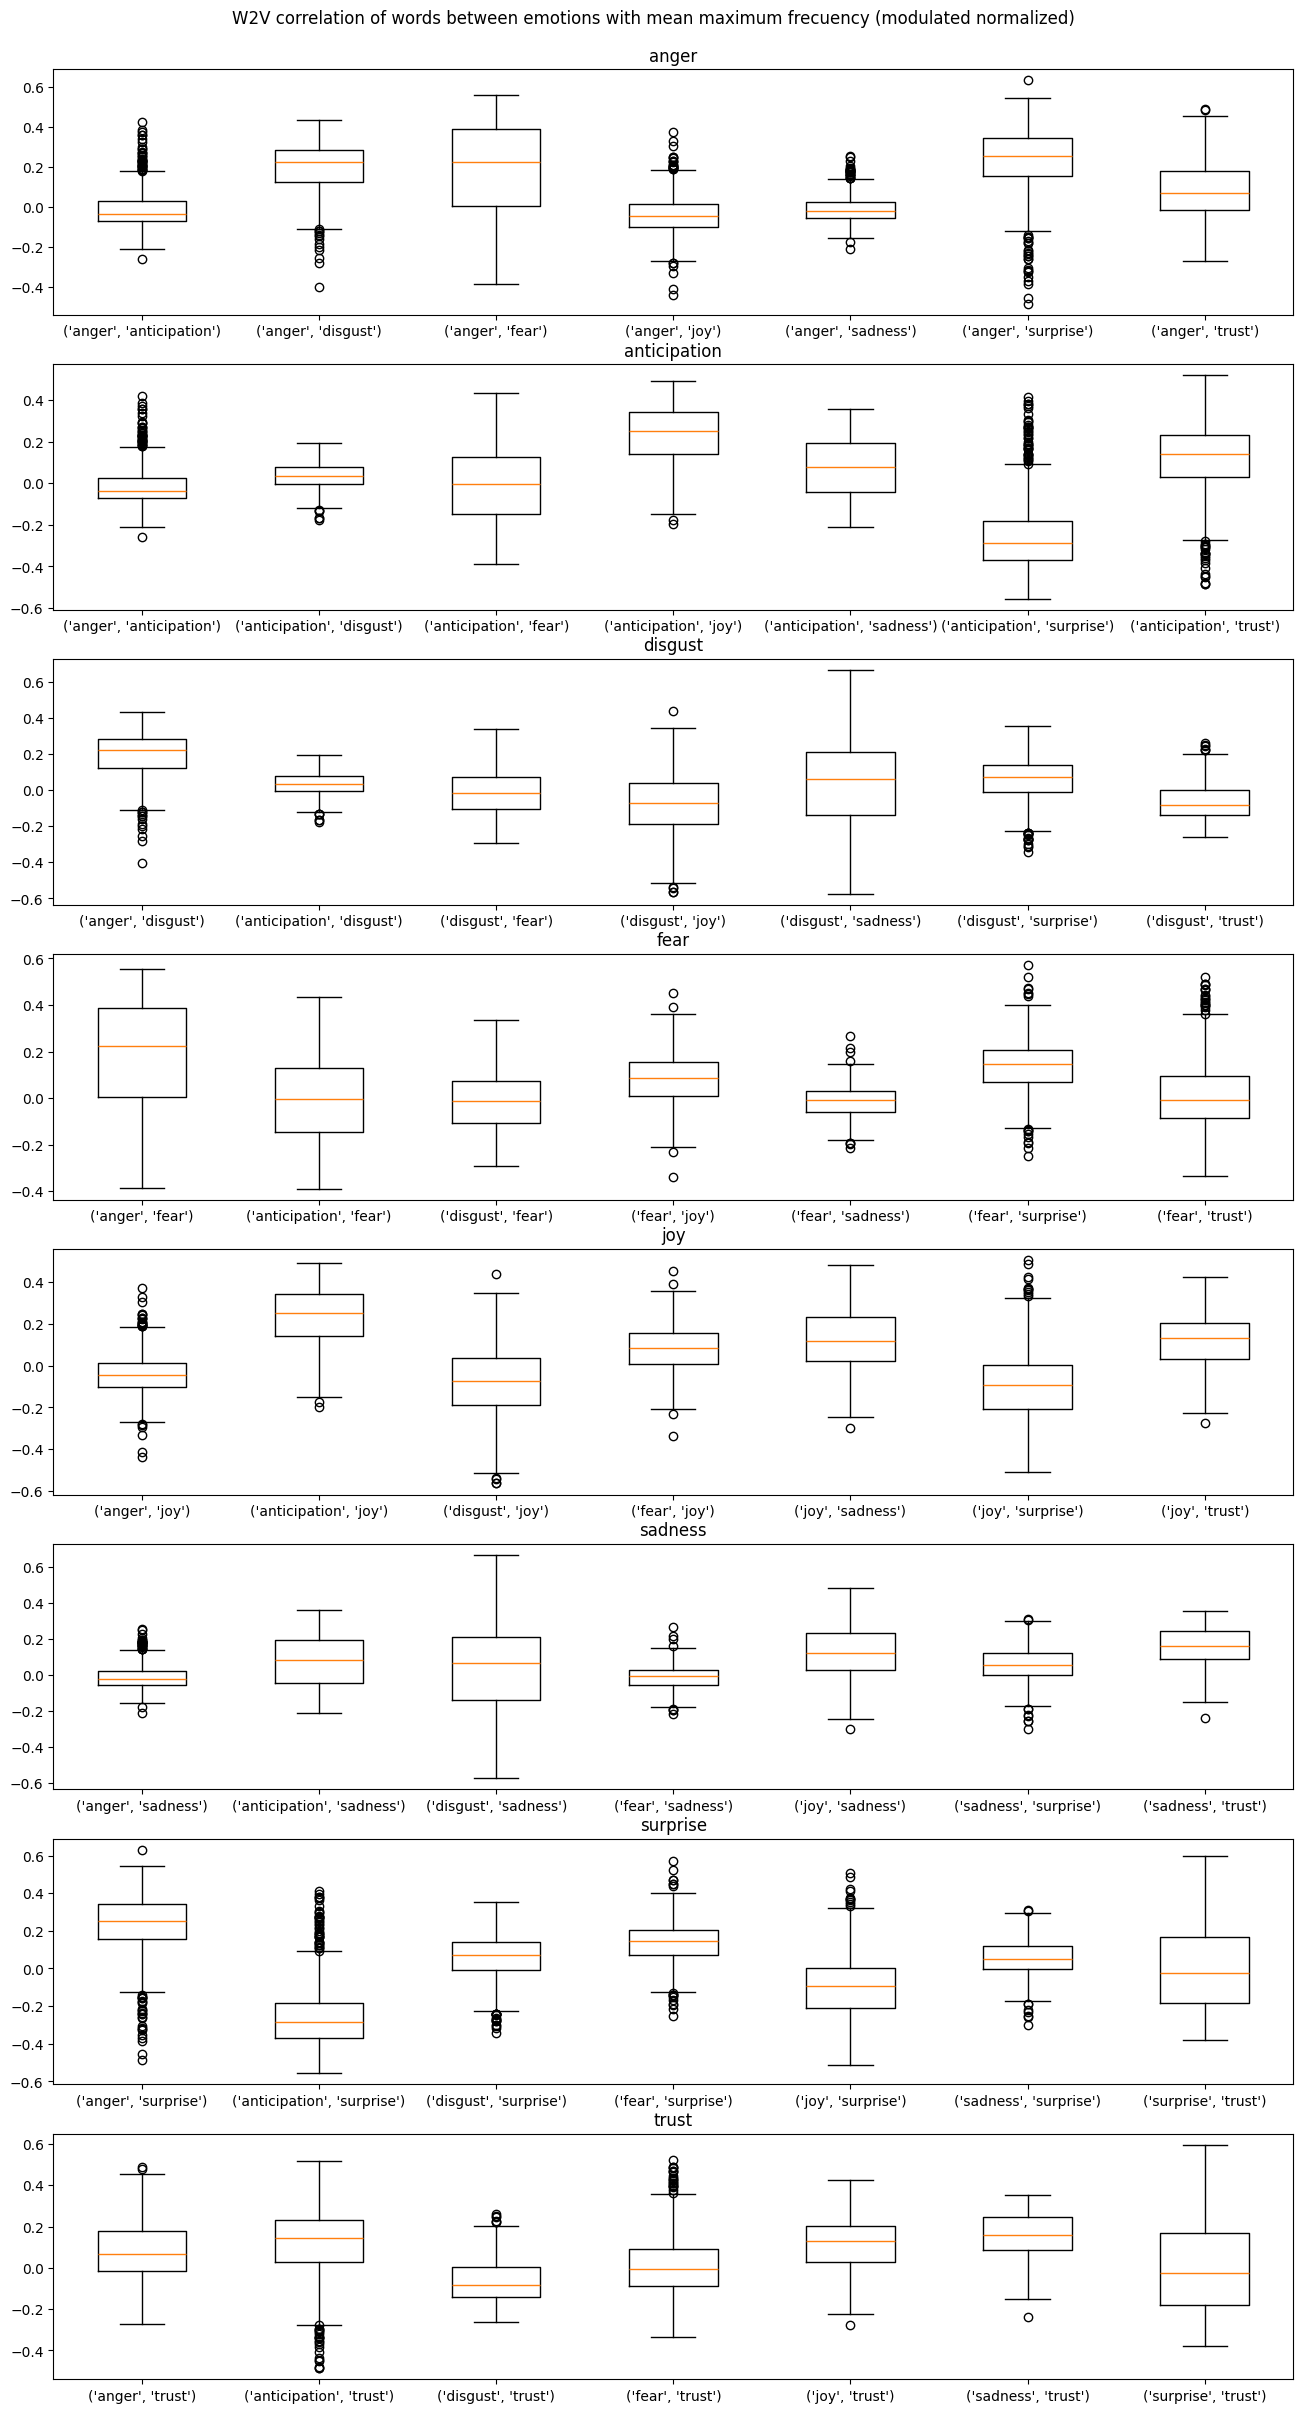

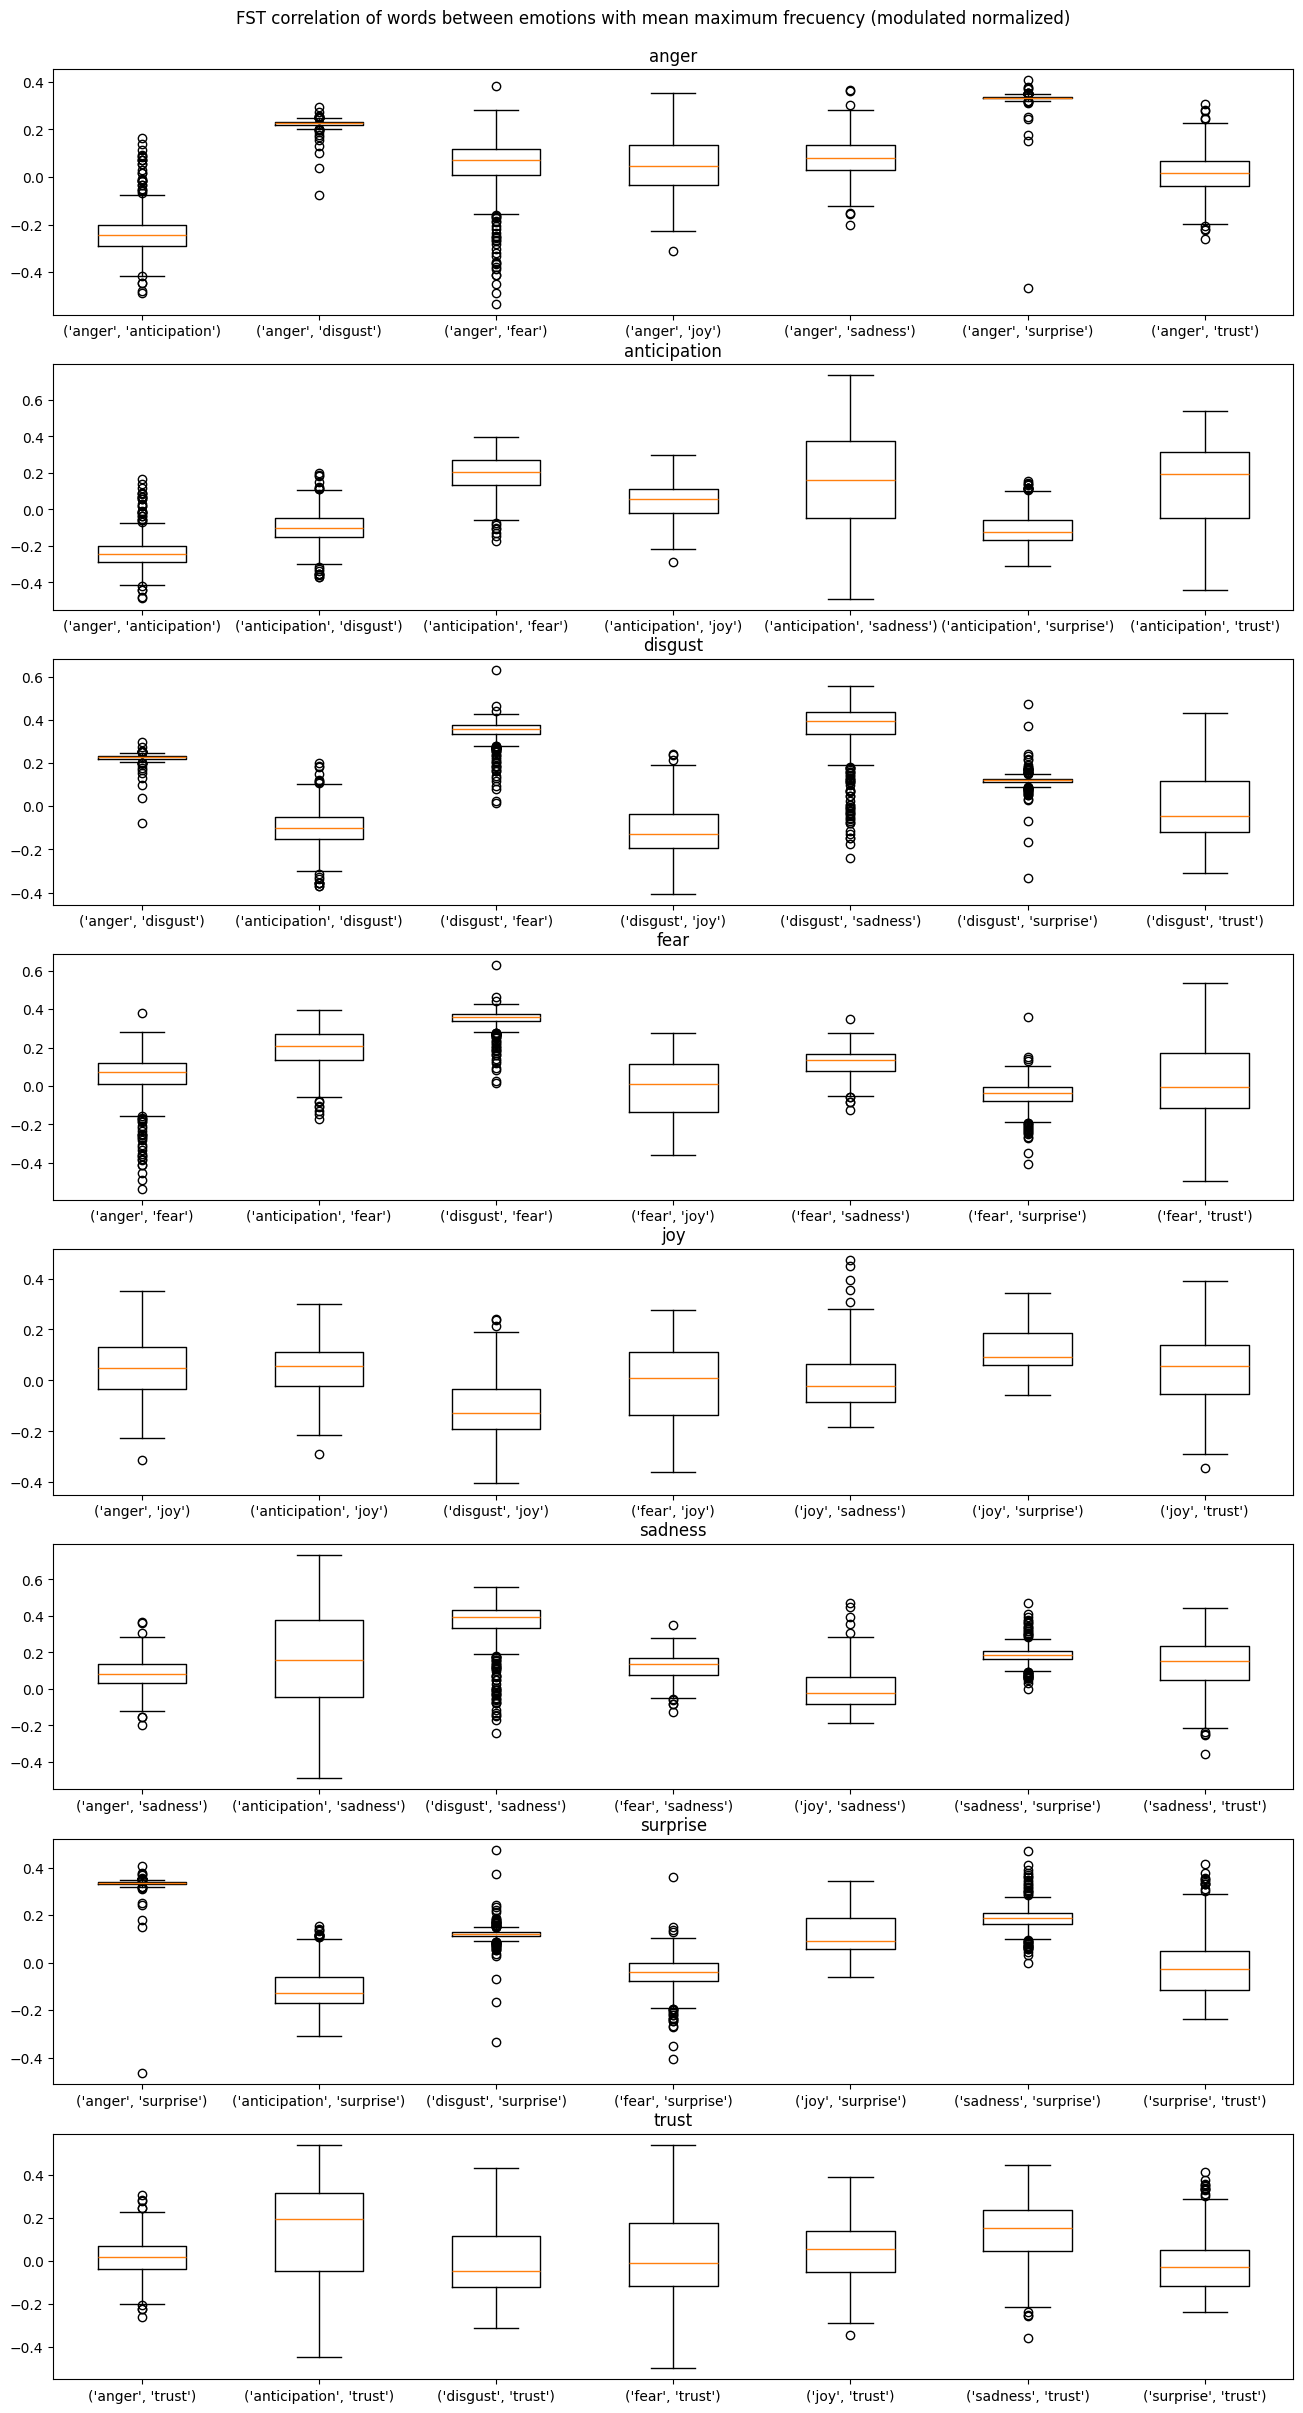

In [52]:
box_plot_word_info(mod_per_emotion_info_w2v,"W2V correlation of words between emotions with mean maximum frecuency (modulated normalized)")
box_plot_word_info(mod_per_emotion_info_fst,"FST correlation of words between emotions with mean maximum frecuency (modulated normalized)")

## Creacion de datasets

In [55]:
def create_data_frame(models,name,emotion_frecuencies,emotion_list=None,modulate=False,norm=False):
    with open(name, 'w') as archivo:
        #Escribe el header del dataset
        header = ""
        for i in range(100):
            header += "N"+str(i)+","
        header += "emotion\n"
        archivo.write(header)

        for emotion in emotion_list:
            #Obtiene las palabras en el modelo
            words = models[emotion].wv.key_to_index.keys()
            for word in words:
                vector = models.wv.get_vector(word,norm=True)

                if modulate:
                    vector = modulate(vector,emotion_frecuencies[emotion],1000,1/len(vector),1)

                if norm:
                    vector = vector/np.linalg.norm(vector)

                info = ""
                for i in range(len(vector)):
                    info += str(vector[i]) + ","
                info += str(emotion)
                archivo.write(info+"\n")

In [56]:
create_data_frame(poems_w2v,"w2v_mod.csv",emotion_carrier_frecuencies_w2v,emotion_list,True)
create_data_frame(poems_fst,"fst_mod.csv",emotion_carrier_frecuencies_fst,emotion_list,True)

In [ ]:
create_data_frame(poems_w2v,"embeddings_w2v.csv",emotion_list)
create_data_frame(poems_fst,"embeddings_fst.csv",emotion_list)

## Prueba de siluetas

In [57]:
#Carga datasets modulados
df_w2v_mod = pd.read_csv("w2v_mod.csv")
df_fst_mod = pd.read_csv("fst_mod.csv")

display(df_w2v_mod)
display(df_fst_mod)

,N0,N1,N2,N3,N4,N5,N6,N7,N8,N9,...,N91,N92,N93,N94,N95,N96,N97,N98,N99,emotion
0,1.0,0.98818,0.909223,0.156370,0.078461,-0.653752,0.279902,0.982709,-0.215609,-0.760165,...,0.978810,0.243130,0.107599,-0.050407,-0.921630,0.161464,0.644784,0.663154,0.032057,anger
1,1.0,0.98818,0.913263,0.169935,0.109878,-0.613853,0.308559,0.973735,-0.172379,-0.784342,...,0.956419,0.147350,0.021614,-0.124006,-0.942906,0.211490,0.686322,0.708083,0.085224,anger
2,1.0,0.98818,0.913051,0.175388,0.121024,-0.608849,0.307640,0.977800,-0.175674,-0.787773,...,0.978151,0.233536,0.093114,-0.054206,-0.920415,0.160522,0.652876,0.681681,0.057885,anger
3,1.0,0.98818,0.909136,0.155998,0.106429,-0.618675,0.304799,0.971371,-0.148453,-0.798713,...,0.948571,0.122403,-0.005380,-0.157832,-0.957972,0.266334,0.724642,0.744844,0.144443,anger
4,1.0,0.98818,0.912110,0.176997,0.134671,-0.573223,0.347405,0.962172,-0.117539,-0.819077,...,0.952458,0.126875,0.009237,-0.142492,-0.948517,0.214127,0.672636,0.693243,0.087133,anger
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
153084,1.0,1.00000,0.468993,-0.345718,-0.484831,-0.930288,-0.976526,-0.703727,0.476452,-0.017454,...,-0.517121,0.258563,0.948322,0.485236,0.173076,0.792110,-0.228231,-0.917787,-0.988540,trust
153085,1.0,1.00000,0.794413,0.818354,0.819659,0.085706,0.799293,-0.214106,-0.990021,-0.907627,...,-0.497414,-0.359874,-0.517208,-0.025618,0.950403,0.676728,-0.214643,0.348712,0.381282,trust
153086,1.0,1.00000,0.838814,-0.471839,-0.081576,0.009872,0.760414,0.383697,0.933667,-0.995048,...,-0.693579,-0.900188,-0.024024,0.503260,-0.327104,-0.945577,-0.879264,0.215434,0.293125,trust
153087,1.0,1.00000,0.954546,0.646279,0.979569,0.776209,0.999199,0.689422,0.457412,-0.999876,...,-0.900668,0.204016,0.531139,0.250691,0.942239,-0.063234,-0.877596,-0.269553,0.728802,trust


,N0,N1,N2,N3,N4,N5,N6,N7,N8,N9,...,N91,N92,N93,N94,N95,N96,N97,N98,N99,emotion
0,1.0,0.846627,-0.038183,-0.539257,-0.758074,-0.656800,0.746937,0.262469,-0.577393,0.203403,...,-0.950909,-0.771712,-0.628517,-0.253086,0.614920,0.887420,0.679635,0.883507,0.985122,anger
1,1.0,0.846627,-0.042574,-0.551316,-0.775092,-0.634737,0.771759,0.222712,-0.605195,0.251917,...,-0.836799,-0.579581,-0.389666,0.038875,0.835463,0.989892,0.397834,0.685851,0.986992,anger
2,1.0,0.846627,-0.054249,-0.554848,-0.766806,-0.640357,0.778944,0.212872,-0.613932,0.277795,...,-0.902863,-0.680282,-0.487564,-0.069965,0.764133,0.965181,0.508388,0.769593,0.999176,anger
3,1.0,0.846627,-0.044744,-0.546461,-0.762911,-0.655124,0.745842,0.280081,-0.569982,0.220102,...,-0.831357,-0.570847,-0.378833,0.034735,0.841664,0.991644,0.400592,0.692560,0.988507,anger
4,1.0,0.846627,-0.047911,-0.547364,-0.762058,-0.660984,0.744691,0.282131,-0.562162,0.210051,...,-0.904928,-0.681576,-0.515609,-0.112266,0.758094,0.962325,0.533178,0.786665,0.999516,anger
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29284,1.0,0.913441,0.713134,0.980553,0.739837,0.209907,0.074041,-0.733255,-0.994653,-0.421809,...,0.994320,0.642817,0.739466,0.555368,-0.244131,-0.376452,-0.989732,-0.998871,-0.954895,trust
29285,1.0,0.913441,0.132606,-0.127917,0.140716,-0.949216,-0.574558,0.995491,0.537037,-0.999963,...,0.466976,-0.025009,0.324802,0.398506,0.587366,0.559855,0.951048,0.984569,0.586062,trust
29286,1.0,0.913441,0.480211,0.065711,0.227825,-0.782816,-0.834434,0.757520,0.993599,-0.538775,...,-0.999294,-0.904572,-0.971185,-0.990304,-0.931754,-0.985014,0.205635,-0.661394,-0.974695,trust
29287,1.0,0.913441,0.241342,-0.040082,0.184994,-0.826069,-0.846519,0.857298,0.974532,-0.516371,...,-0.496260,-0.843344,-0.615807,-0.649962,-0.473895,-0.526470,0.721700,0.191052,-0.607606,trust


In [60]:
#Carga datasets no modulados
df_w2v = pd.read_csv("embeddings_w2v.csv")
df_fst = pd.read_csv("embeddings_fst.csv")

columns = ["N"+str(i) for i in range(100)]
columns.append("emotion")

df_w2v.columns = columns
df_fst.columns = columns

display(df_w2v)
display(df_fst)

,N0,N1,N2,N3,N4,N5,N6,N7,N8,N9,...,N91,N92,N93,N94,N95,N96,N97,N98,N99,emotion
0,-0.076017,0.098369,-0.035965,0.054840,-0.026230,-0.217908,0.067091,0.285832,-0.090627,-0.118877,...,0.039860,-0.005281,0.014511,0.230754,0.106384,0.051394,-0.090605,0.017354,-0.018768,anger
1,-0.075675,0.098132,-0.037018,0.055113,-0.026506,-0.215662,0.065859,0.284593,-0.091683,-0.117410,...,0.041211,-0.005131,0.014910,0.231864,0.107144,0.052365,-0.090009,0.019289,-0.020563,anger
2,-0.075176,0.099532,-0.037218,0.054520,-0.026098,-0.218705,0.065259,0.285227,-0.090379,-0.119095,...,0.039926,-0.004971,0.015748,0.231975,0.106573,0.051070,-0.090186,0.017661,-0.020198,anger
3,-0.074783,0.097700,-0.036672,0.051563,-0.025413,-0.217620,0.066402,0.284785,-0.089330,-0.118217,...,0.039304,-0.004678,0.014940,0.229902,0.104336,0.049662,-0.088757,0.017867,-0.018339,anger
4,-0.076661,0.097841,-0.036690,0.053070,-0.027791,-0.217017,0.066852,0.285037,-0.091078,-0.118978,...,0.041365,-0.006535,0.014888,0.231418,0.106698,0.051201,-0.091072,0.018862,-0.020140,anger
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
153083,0.080684,0.135845,-0.046924,0.139007,-0.031085,0.039498,-0.002538,0.318500,-0.089557,-0.074771,...,0.128439,-0.029309,-0.105323,0.128416,-0.048856,-0.054254,-0.146695,0.193412,-0.102059,trust
153084,-0.088212,-0.042339,0.073892,0.166642,-0.111289,0.009717,0.162898,0.032578,-0.016663,-0.037545,...,0.007572,0.004706,-0.130327,-0.022834,0.133162,-0.068558,-0.001080,-0.109375,-0.169702,trust
153085,-0.059277,0.174416,-0.019735,-0.031871,-0.003156,-0.206303,0.006992,0.317939,-0.013038,-0.164387,...,-0.056467,-0.084445,-0.008515,0.211270,0.036823,-0.136240,-0.084599,0.063095,-0.001143,trust
153086,-0.038814,0.099347,-0.098145,0.017154,-0.026252,-0.127890,0.090131,0.287609,-0.050324,-0.121548,...,0.098052,-0.042242,0.013625,0.188535,0.175217,0.005546,-0.165326,0.089538,0.021733,trust


,N0,N1,N2,N3,N4,N5,N6,N7,N8,N9,...,N91,N92,N93,N94,N95,N96,N97,N98,N99,emotion
0,0.059186,0.039018,-0.073900,0.064061,0.041944,0.187644,-0.047828,0.189275,0.040273,-0.166675,...,-0.026101,-0.050626,0.046495,-0.055288,0.068559,-0.032620,-0.151968,0.003732,0.094632,anger
1,0.061217,0.039325,-0.075888,0.063163,0.044064,0.188553,-0.048372,0.190554,0.040730,-0.167869,...,-0.024226,-0.049824,0.045615,-0.055648,0.068222,-0.032374,-0.152015,0.004659,0.092771,anger
2,0.059904,0.038735,-0.075227,0.062948,0.041459,0.185046,-0.046734,0.190788,0.041092,-0.167586,...,-0.025179,-0.053113,0.046848,-0.054321,0.067458,-0.033497,-0.152285,0.003865,0.093766,anger
3,0.060685,0.038588,-0.075097,0.062135,0.041925,0.185592,-0.047688,0.190658,0.040118,-0.167170,...,-0.025846,-0.052954,0.047885,-0.054665,0.066767,-0.033455,-0.150130,0.004066,0.095312,anger
4,0.059405,0.039067,-0.074008,0.063049,0.042403,0.187009,-0.047146,0.190137,0.040263,-0.167577,...,-0.025504,-0.052982,0.047856,-0.054509,0.067966,-0.032904,-0.153262,0.003382,0.093903,anger
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29283,0.082467,-0.094754,-0.021412,0.044419,-0.059212,0.036000,-0.025895,0.102657,-0.071299,-0.036085,...,-0.004739,-0.061321,0.055006,-0.086515,0.082275,-0.053785,-0.043912,0.025368,0.075015,trust
29284,0.072585,0.047321,-0.129371,0.051196,0.009845,0.200805,0.002448,0.153782,0.047512,-0.162620,...,-0.031858,-0.055588,0.000956,-0.110620,0.068529,-0.037822,-0.143992,-0.015330,0.070479,trust
29285,0.003866,0.042460,-0.099416,0.027585,0.027075,0.162879,0.000503,0.129058,0.087105,-0.179637,...,0.009854,-0.080135,0.005288,-0.153216,0.098032,-0.068496,-0.194542,-0.005824,0.097136,trust
29286,0.057304,0.040452,-0.113065,0.034124,0.004688,0.177151,-0.004925,0.126790,0.042543,-0.164007,...,-0.027528,-0.071526,-0.002248,-0.120056,0.076470,-0.047319,-0.156954,-0.014137,0.079877,trust


In [61]:
#Carga de funcion siluette score
from sklearn.metrics import silhouette_score

X_w2v = df_w2v.drop(columns=["emotion"],inplace=False)
y_w2v = df_w2v["emotion"]

X_fst = df_fst.drop(columns=["emotion"],inplace=False)
y_fst = df_fst["emotion"]

X_w2v_mod = df_w2v_mod.drop(columns=["emotion"],inplace=False)
y_w2v_mod = df_w2v_mod["emotion"]

X_fst_mod = df_fst_mod.drop(columns=["emotion"],inplace=False)
y_fst_mod = df_fst_mod["emotion"]

In [62]:
print("No moduladas w2v",silhouette_score(X_w2v,y_w2v))
print("No moduladas fst",silhouette_score(X_fst,y_fst))

print("Moduladas w2v",silhouette_score(X_w2v_mod,y_w2v_mod))
print("Moduladas fst",silhouette_score(X_fst_mod,y_fst_mod))

No moduladas w2v 0.0773267010339552
No moduladas fst 0.5801626551918806
Moduladas w2v 0.0009782464308104536
Moduladas fst 0.4678943412362683


## Prueba clasificacion

In [80]:
#Separacion del dataset no modulado
from sklearn.model_selection import train_test_split

X_w2v = df_w2v.drop(columns=["emotion"],inplace=False)
y_w2v = df_w2v["emotion"]

X_fst = df_fst.drop(columns=["emotion"],inplace=False)
y_fst = df_fst["emotion"]

X_train_w2v, X_test_w2v, y_train_w2v, y_test_w2v = train_test_split(X_w2v,y_w2v,test_size=0.3,random_state=0)
X_train_fst, X_test_fst, y_train_fst, y_test_fst = train_test_split(X_fst,y_fst,test_size=0.3,random_state=0)

In [81]:
#Separacion del dataset modulado
X_w2v_mod = df_w2v_mod.drop(columns=["emotion"],inplace=False)
y_w2v_mod = df_w2v_mod["emotion"]

X_fst_mod = df_fst_mod.drop(columns=["emotion"],inplace=False)
y_fst_mod = df_fst_mod["emotion"]

X_train_w2v_mod, X_test_w2v_mod, y_train_w2v_mod, y_test_w2v_mod = train_test_split(X_w2v_mod,y_w2v_mod,test_size=0.3,random_state=0)
X_train_fst_mod, X_test_fst_mod, y_train_fst_mod, y_test_fst_mod = train_test_split(X_fst_mod,y_fst_mod,test_size=0.3,random_state=0)

In [82]:
#Importamos escaladores y hacemos fit de los escaladores
from sklearn.preprocessing import MinMaxScaler

scaler_w2v = MinMaxScaler()
scaler_fst = MinMaxScaler()

scaler_w2v_mod = MinMaxScaler()
scaler_fst_mod = MinMaxScaler()

X_train_w2v = scaler_w2v.fit_transform(X_train_w2v)
X_train_fst = scaler_fst.fit_transform(X_train_fst)

X_train_w2v_mod = scaler_w2v_mod.fit_transform(X_train_w2v_mod)
X_train_fst_mod = scaler_fst_mod.fit_transform(X_train_fst_mod)

In [83]:
#Importamos y entrenamos los modelo de regresión logistica
from sklearn.linear_model import LogisticRegression

#Modelo con no modulados
lr_w2v = LogisticRegression(solver = 'lbfgs',penalty='l2', C=1,max_iter=200)
lr_fst = LogisticRegression(solver = 'lbfgs',penalty='l2', C=0.1)

lr_w2v.fit(X_train_w2v,y_train_w2v)
lr_fst.fit(X_train_fst,y_train_fst)

#Modelo con modulados
lr_w2v_mod = LogisticRegression(solver = 'lbfgs',penalty='l2', C=1,max_iter=200)
lr_fst_mod = LogisticRegression(solver = 'lbfgs',penalty='l2', C=0.1)

lr_w2v_mod.fit(X_train_w2v_mod,y_train_w2v_mod)
lr_fst_mod.fit(X_train_fst_mod,y_train_fst_mod)


d:\Projects\MODULACION\.env\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(C=0.1)

In [84]:
#Revisamos metricas en training no modulados
from sklearn.metrics import classification_report

y_pred_w2v = lr_w2v.predict(X_train_w2v)
y_pred_fst = lr_fst.predict(X_train_fst)

print("Training no modulados")
print("W2V",classification_report(y_train_w2v,y_pred_w2v))
print("FST",classification_report(y_train_fst,y_pred_fst))

Training no modulados
W2V               precision    recall  f1-score   support

       anger       0.91      0.89      0.90      9600
anticipation       0.92      0.92      0.92     16371
     disgust       0.88      0.85      0.86      6972
        fear       0.92      0.92      0.92     14815
         joy       0.91      0.92      0.92     16522
     sadness       0.91      0.91      0.91     16635
    surprise       0.90      0.86      0.88      5053
       trust       0.91      0.92      0.92     21193

    accuracy                           0.91    107161
   macro avg       0.91      0.90      0.90    107161
weighted avg       0.91      0.91      0.91    107161

FST               precision    recall  f1-score   support

       anger       1.00      1.00      1.00      1419
anticipation       1.00      1.00      1.00      3305
     disgust       1.00      1.00      1.00       880
        fear       1.00      1.00      1.00      2846
         joy       1.00      1.00      1.00     

In [85]:
#Revisamos metricas en training modulaods
y_pred_w2v_mod = lr_w2v_mod.predict(X_train_w2v_mod)
y_pred_fst_mod = lr_fst_mod.predict(X_train_fst_mod)

print("Training modulado")
print("W2V",classification_report(y_train_w2v_mod,y_pred_w2v_mod))
print("FST",classification_report(y_train_fst_mod,y_pred_fst_mod))

Training modulado
W2V               precision    recall  f1-score   support

       anger       0.84      0.69      0.76      9601
anticipation       0.63      0.64      0.64     16371
     disgust       0.98      0.86      0.92      6972
        fear       0.65      0.63      0.64     14815
         joy       0.84      0.92      0.88     16570
     sadness       0.94      0.99      0.96     16611
    surprise       0.75      0.36      0.49      4987
       trust       0.69      0.78      0.73     21235

    accuracy                           0.77    107162
   macro avg       0.79      0.73      0.75    107162
weighted avg       0.77      0.77      0.77    107162

FST               precision    recall  f1-score   support

       anger       1.00      1.00      1.00      1420
anticipation       1.00      0.99      0.99      3304
     disgust       1.00      1.00      1.00       881
        fear       1.00      1.00      1.00      2874
         joy       1.00      1.00      1.00      350

In [86]:
#Probamos en el testing no modulado
X_test_w2v_scaled = scaler_w2v.transform(X_test_w2v)
X_test_fst_scaled = scaler_fst.transform(X_test_fst)

y_pred_w2v = lr_w2v.predict(X_test_w2v_scaled)
y_pred_fst = lr_fst.predict(X_test_fst_scaled)

print("W2V",classification_report(y_test_w2v,y_pred_w2v))
print("FST",classification_report(y_test_fst,y_pred_fst))

W2V               precision    recall  f1-score   support

       anger       0.91      0.89      0.90      4119
anticipation       0.91      0.91      0.91      6900
     disgust       0.87      0.84      0.86      3016
        fear       0.92      0.92      0.92      6171
         joy       0.92      0.91      0.92      7112
     sadness       0.90      0.91      0.91      7165
    surprise       0.89      0.86      0.87      2227
       trust       0.90      0.92      0.91      9217

    accuracy                           0.91     45927
   macro avg       0.90      0.90      0.90     45927
weighted avg       0.91      0.91      0.91     45927

FST               precision    recall  f1-score   support

       anger       1.00      1.00      1.00       631
anticipation       1.00      1.00      1.00      1370
     disgust       1.00      1.00      1.00       360
        fear       1.00      1.00      1.00      1226
         joy       1.00      1.00      1.00      1506
     sadness    

In [87]:
#Probamos en el testing modulado
X_test_w2v_mod_scaled = scaler_w2v_mod.transform(X_test_w2v_mod)
X_test_fst_mod_scaled = scaler_fst_mod.transform(X_test_fst_mod)

y_pred_w2v_mod = lr_w2v_mod.predict(X_test_w2v_mod_scaled)
y_pred_fst_mod = lr_fst_mod.predict(X_test_fst_mod_scaled)

print("W2V",classification_report(y_test_w2v_mod,y_pred_w2v_mod))
print("FST",classification_report(y_test_fst_mod,y_pred_fst_mod))

W2V               precision    recall  f1-score   support

       anger       0.83      0.67      0.74      4119
anticipation       0.63      0.63      0.63      6900
     disgust       0.98      0.86      0.92      3016
        fear       0.63      0.63      0.63      6171
         joy       0.83      0.92      0.87      7064
     sadness       0.94      0.99      0.96      7189
    surprise       0.75      0.35      0.48      2293
       trust       0.69      0.79      0.74      9175

    accuracy                           0.77     45927
   macro avg       0.79      0.73      0.75     45927
weighted avg       0.77      0.77      0.76     45927

FST               precision    recall  f1-score   support

       anger       1.00      1.00      1.00       631
anticipation       1.00      0.99      0.99      1371
     disgust       1.00      1.00      1.00       359
        fear       1.00      1.00      1.00      1198
         joy       0.99      1.00      1.00      1500
     sadness    